In [ ]:
!pip install --upgrade pip
!pip install torch torchvision scipy tdqm matplotlib trasnformers

# Google Drive Mount

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Import Modules

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

from scipy.linalg import sqrtm
import numpy as np
import os

from tqdm import tqdm
from matplotlib import pyplot as plt

In [81]:
def image_normalize(image):
    image = image.cpu()
    n_channels = image.shape[0]
    for channel in range(n_channels):
        max_value = torch.max(image[channel])
        min_value = torch.min(image[channel])
        image[channel] = (image[channel] - min_value) / (max_value - min_value)

    image = image.permute(1, 2, 0)

    return image

def print_image(image):
    image = image_normalize(image)
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()

def print_2images(image1, image2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image_normalize(image1))
    axes[0].set_title('Image 1')

    axes[1].imshow(image_normalize(image2))
    axes[1].set_title('Image 2')

    plt.tight_layout()
    plt.show()

def print_result(result):
    for image, noised_image, denoised_image in result:
        batch_size = image.shape[0]
        for idx in range(batch_size):
            print_2images(image[idx], denoised_image[idx])
            # print_image(image[idx])
            # print_image(noised_image[idx])
            # print_image(denoised_image[idx])


def print_loss(loss_values):
    epochs = list(range(1, len(loss_values) + 1))
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss_values, 'b-o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# NoiseSchedule
- betas, alphas

In [4]:
class NoiseSchedule:

    def __init__(self, n_timesteps, beta_start=0.0001, beta_end=0.02, device=device, init_type='linear') -> None:
        self._size = n_timesteps
        if init_type == 'linear':
            self._betas = torch.linspace(beta_start, beta_end, n_timesteps).to(device)
        if init_type == 'exponential':
            self._betas = torch.from_numpy(np.geomspace(beta_start, beta_end, n_timesteps)).to(device)
        self._alphas = self._calculate_alphas()

        # print(self._betas)
        # print(self._alphas)

    def _calculate_alphas(self):
        self._alphas = torch.cumprod(1 - self._betas, axis=0)
        return self._alphas

    def get_beta(self, index):
        if index >= self._size:
            raise IndexError("[get] out of index :", index, " / size :", self._size)
        return self._betas[index]

    def get_alpha(self, index):
        if index >= self._size:
            raise IndexError("[get] out of index :", index, " / size :", self._size)
        return self._alphas[index]

# ForwardEncoder

In [5]:
class ForwardEncoder:

    def __init__(self, noise_schedule) -> None:
        self.noise_schedule = noise_schedule

    def noise(self, data, time_step):
        # time_step : [B]
        # data : [B, 1, 32, 32]

        alpha = self.noise_schedule._alphas[time_step]
        alpha = alpha.reshape(-1, 1, 1, 1)
        # alpha : [B, 1, 1, 1]

        epsilon = torch.randn(data.shape).to(device)
        # torch.randn ~ N(0, 1)

        return torch.sqrt(alpha) * data + torch.sqrt(1 - alpha) * epsilon, epsilon

# ReverseDecoder

In [69]:
import torch

class ReverseDecoder:

    def __init__(self, noise_schedule, g) -> None:
        self.noise_schedule = noise_schedule
        self.g = g

    def denoise(self, noise_data, time_step):
        # noise_data : [B, 1, 32, 32]
        # time_step : INT

        batch_size = noise_data.shape[0]
        # batch_size : B

        with torch.no_grad():

            # step : [T - 1, T - 2, .. 2, 1, 0]
            for step in range(time_step - 1, -1, -1):

                t = torch.full((batch_size, ), step).to(device)
                t = t.reshape(-1, 1, 1, 1)
                # t : [B, 1, 1, 1]

                mu = 1 / torch.sqrt(1 - self.noise_schedule._betas[t]) * (noise_data - (self.noise_schedule._betas[t] / (1 - self.noise_schedule._alphas[t])) * self.g(noise_data, t))
                # mu : [B, 1, 32, 32]

                if step == 0:
                    # if t == 0, no add noise
                    break

                epsilon = torch.randn(noise_data.shape).to(device)
                # epsilon : [B, 1, 32, 32]

                noise_data = mu + torch.sqrt(self.noise_schedule._betas[t]) * epsilon
                # noise_data : [B, 1, 32, 32]

        return noise_data

    def implicit_denoise(self, noise_data, time_step, n_jumps=10, sigma=0):
        # noise_data : [B, 1, 32, 32]
        # time_step : INT

        batch_size = noise_data.shape[0]
        gap = (time_step - 1) // n_jumps
        tau = [time_step - 1 - t * gap for t in range(n_jumps)]
        S = len(tau)
        # print(tau)

        # batch_size : B
        with torch.no_grad():

            # step : [T - 1, T - 2, .. 2, 1, 0]
            for i in range(S):

                t = torch.full((batch_size, ), tau[i]).to(device)
                t = t.reshape(-1, 1, 1, 1)
                alpha_t = self.noise_schedule._alphas[t]

                alpha_t_1 = torch.full((batch_size, 1, 1, 1,), 1).to(device)
                if i < S - 1:
                    t_1 = torch.full((batch_size, ), tau[i + 1]).to(device)
                    t_1 = t_1.reshape(-1, 1, 1, 1)
                    alpha_t_1 = self.noise_schedule._alphas[t_1]

                predict_noise = self.g(noise_data, t)
                first = torch.sqrt(alpha_t / alpha_t_1) * (noise_data - torch.sqrt(1 - alpha_t) * predict_noise)
                second = torch.sqrt(1 - alpha_t_1) * predict_noise

                noise_data = first + second

        return noise_data

# UNet

In [7]:

def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

class MyConv(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyConv, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        return out
    

class MyTimeEmbedding(nn.Module):
    
    def __init__(self, dim_in, dim_out):
        super(MyTimeEmbedding, self).__init__()
        self.linear1 = nn.Linear(dim_in, dim_out)
        self.activation = nn.SiLU()
        self.linear2 = nn.Linear(dim_out, dim_out)

    def forward(self, x, batch_size):
        out = self.linear1(x)
        out = self.activation(out)
        out = self.linear2(out)
        return out.reshape(batch_size, -1, 1, 1)


# [B, in_c, 32, 32] -> [B, out_c, 32, 32]
def MyTinyBlock(size, in_c, out_c):
    return nn.Sequential(MyConv((in_c, size, size), in_c, out_c),
                         MyConv((out_c, size, size), out_c, out_c),
                         MyConv((out_c, size, size), out_c, out_c))

# [B, in_c, 32, 32] -> [B, in_c // 4, 32, 32]
def MyTinyUp(size, in_c):
    return nn.Sequential(MyConv((in_c, size, size), in_c, in_c//2),
                         MyConv((in_c//2, size, size), in_c//2, in_c//4),
                         MyConv((in_c//4, size, size), in_c//4, in_c//4))

class UNet(nn.Module):
  # Here is a network with 3 down and 3 up with the tiny block
    def __init__(self, in_channels=1, out_channels=1, size=32, 
                 n_steps=1000,
                 time_emb_dim=256,
                 n_classes=10,
                 class_emb_dim=64,
                 channel_scale=64):
        super(UNet, self).__init__()

        ### Sinusoidal embedding

        # [1] -> [time_emb_dim]
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)
        
        # [1] -> [class_emb_dim]
        self.class_embed = nn.Embedding(n_classes, class_emb_dim)
        self.class_embed.weight.data = sinusoidal_embedding(n_classes, class_emb_dim)
        self.class_embed.requires_grad_(False)

        ### Downsampling
        self.te_enc1 = MyTimeEmbedding(time_emb_dim, 1)
        self.te_enc2 = MyTimeEmbedding(time_emb_dim, channel_scale)
        self.te_enc3 = MyTimeEmbedding(time_emb_dim, channel_scale * 2)

        self.enc1 = MyTinyBlock(size, in_channels, channel_scale)
        self.enc2 = MyTinyBlock(size//2, channel_scale, channel_scale * 2)
        self.end3 = MyTinyBlock(size//4, channel_scale * 2, channel_scale * 4)

        self.down1 = nn.Conv2d(channel_scale, channel_scale, kernel_size=4, stride=2, padding=1)
        self.down2 = nn.Conv2d(channel_scale * 2, channel_scale * 2, kernel_size=4, stride=2, padding=1)
        self.down3 = nn.Conv2d(channel_scale * 4, channel_scale * 4, kernel_size=4, stride=2, padding=1)

        ### Bottleneck
        self.te_bottleneck = MyTimeEmbedding(time_emb_dim, channel_scale * 4)
        self.bottleneck = nn.Sequential(
            MyConv((channel_scale * 4, size//8, size//8), channel_scale * 4, channel_scale * 2),
            MyConv((channel_scale * 2, size//8, size//8), channel_scale * 2, channel_scale * 2),
            MyConv((channel_scale * 2, size//8, size//8), channel_scale * 2, channel_scale * 4)
        )

        ### Upsampling

        self.dec1 = nn.ConvTranspose2d(channel_scale * 4, channel_scale * 4, kernel_size=4, stride=2, padding=1)
        self.dec2 = nn.ConvTranspose2d(channel_scale * 2, channel_scale * 2, kernel_size=4, stride=2, padding=1)
        self.dec3 = nn.ConvTranspose2d(channel_scale, channel_scale, kernel_size=4, stride=2, padding=1)

        self.te_dec1 = MyTimeEmbedding(time_emb_dim, channel_scale * 8)
        self.te_dec2 = MyTimeEmbedding(time_emb_dim, channel_scale * 4)
        self.te_dec3 = MyTimeEmbedding(time_emb_dim, channel_scale * 2)

        self.up1 = MyTinyUp(size//4, channel_scale * 8)
        self.up2 = MyTinyUp(size//2, channel_scale * 4)
        self.up3 = MyTinyBlock(size, channel_scale * 2, channel_scale)

        self.conv_out = nn.Conv2d(channel_scale, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x, t, c=-1):
        # x : [B, 1, 32, 32]
        # t : [B]

        t = self.time_embed(t)
        n = len(x)
        # t : [B, time_emb_dim]
        # n : B

        ### Downsampling
        enc1 = self.enc1(x + self.te_enc1(t, n))
        # out1 : (B, 10, 32, 32)

        enc2 = self.enc2(self.down1(enc1) + self.te_enc2(t, n))
        # out2 : (B, 20, 16, 16)

        enc3 = self.end3(self.down2(enc2) + self.te_enc3(t, n))
        # out3 : (B, 40, 8, 8)


        ### Bottleneck
        bottleneck = self.bottleneck(self.down3(enc3) + self.te_bottleneck(t, n))
        # out_mid : (B, 40, 4, 4)
        # 40 -> 20 -> 40

        ### Upsampling
        dec1 = torch.cat((enc3, self.dec1(bottleneck)), dim=1)
        # out4 : (B, 80, 8, 8)

        dec1 = self.up1(dec1 + self.te_dec1(t, n))
        # out4 : (B, 20, 8, 8)

        dec2 = torch.cat((enc2, self.dec2(dec1)), dim=1)
        # out4 : (B, 40, 16, 16)

        dec2 = self.up2(dec2 + self.te_dec2(t, n))
        # out5 : (B, 10, 16, 16)

        dec3 = torch.cat((enc1, self.dec3(dec2)), dim=1)
        # out5 : (B, 20, 32, 32)

        dec3 = self.up3(dec3 + self.te_dec3(t, n))
        # out5 : (B, 10, 32, 32)

        out = self.conv_out(dec3)
        # out : (B, 1, 32, 32)

        return out

# DDPM

In [70]:
class DDPM:

    def __init__(self, n_timesteps,
                 train_set=None,
                 test_set=None,
                 in_channels=1,
                 out_channels=1,
                 channel_scale=64,
                 train_batch_size=8,
                 test_batch_size=8) -> None:

        self.n_timesteps = n_timesteps
        self.channel_scale = channel_scale

        # UNet for predicting total noise
        self.g = UNet(in_channels=in_channels,
                      out_channels=out_channels,
                      n_steps=n_timesteps,
                      channel_scale=channel_scale)
        self.g = self.g.to(device)

        # alpha, betas
        self.noise_schedule = NoiseSchedule(n_timesteps=n_timesteps)

        # forward encoder
        self.encoder = ForwardEncoder(noise_schedule=self.noise_schedule)
        self.decoder = ReverseDecoder(noise_schedule=self.noise_schedule, g=self.g)

        # optimizer
        self.lossFunction = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.g.parameters(), lr=0.0001)

        # datasets
        if train_set:
            self.training_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
        if test_set:
            self.testing_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=True)


    def save(self, path='./model.pt'):
        torch.save(self.g.state_dict(), path)


    def load(self, path='./model.pt'):
        self.g.load_state_dict(torch.load(path))
        self.g.eval()


    def train_one_epoch(self, n_iter_limit=None):
        running_loss = 0

        for i, data in enumerate(tqdm(self.training_loader)):

            # inputs = [B, 1, 32, 32]
            inputs = data[0] # data['image']
            inputs = inputs.to(device)
            # print(inputs.shape)

            batch_size = inputs.shape[0]

            # sampled timestep
            t = torch.randint(0, self.n_timesteps, (batch_size, )).to(device)

            # outputs = [B, 1, 28, 28]
            noised_image, epsilon = self.encoder.noise(inputs, t)
            outputs = self.g(noised_image, t)
            # Utils.print_image(noised_image[0][0])

            # Compute the loss and its gradients
            loss = self.lossFunction(outputs, epsilon)

            # Adjust learning weights
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Gather data and report
            running_loss += loss.item()

            if i == n_iter_limit:
                break

        return running_loss / len(self.training_loader)

    def train(self, n_epoch=5, n_iter_limit=None):
        best_vloss = 1_000_000
        history = []

        for epoch in range(n_epoch):
            print('EPOCH {}:'.format(epoch + 1))

            # Make sure gradient tracking is on, and do a pass over the data
            self.g.train(True)
            avg_loss = self.train_one_epoch(n_iter_limit=n_iter_limit)
            history.append(avg_loss)
            print('# epoch {} avg_loss: {}'.format(epoch + 1, avg_loss))

            if avg_loss < best_vloss:
                best_vloss = avg_loss
                model_path = 'U{}_T{}_E{}.pt'.format(self.channel_scale,
                                                     self.n_timesteps,
                                                     epoch)
                torch.save(self.g.state_dict(), model_path)

            torch.save(torch.tensor(history), 'history.pt')

        return history


    def evaluate(self, num=None, sampling_type='DDPM', n_jumps=10):
        self.decoder.g = self.g
        result = []
        for i, data in enumerate(tqdm(self.testing_loader)):

            # inputs = [B, 1, 32, 32]
            inputs = data[0] # data['image']
            inputs = inputs.to(device)

            batch_size = inputs.shape[0]

            # timestep
            t = torch.full((batch_size, ), self.n_timesteps - 1).to(device)

            # outputs = [B, 1, 28, 28]
            noised_image, epsilon = self.encoder.noise(inputs, t)

            # denoised image
            denoised_image = None
            if sampling_type == 'DDPM':
              denoised_image = self.decoder.denoise(noised_image, self.n_timesteps)
            if sampling_type == 'DDIM':
              denoised_image = self.decoder.implicit_denoise(noised_image,
                                                             self.n_timesteps,
                                                             n_jumps=n_jumps)

            result.append((inputs, noised_image, denoised_image))

            if i == num - 1:
                break

        return result

# Train

In [50]:
TIME_STEPS = 3000
BATCH_SIZE = 512

noise_schedule = NoiseSchedule(n_timesteps=TIME_STEPS, init_type='exponential')

In [71]:
# dataset = load_dataset("junyeong-nero/mnist_32by32").with_format("torch")
# train, test = dataset['train'], dataset['test']

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train = MNIST(root='./data', train=True, download=True, transform=transform)
test = MNIST(root='./data', train=False, download=True, transform=transform)

In [57]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

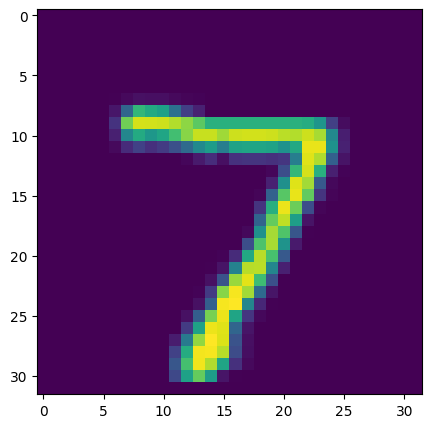

In [58]:
print_image(test[0][0])

In [72]:
model = DDPM(
    n_timesteps=TIME_STEPS,
    in_channels=1,
    out_channels=1,
    channel_scale=128,
    train_set=train,
    test_set=test,
    train_batch_size=BATCH_SIZE,
    test_batch_size=8
)

In [73]:
print("model size : ", sum(p.numel() for p in model.g.parameters() if p.requires_grad))

model size :  35118440


In [ ]:
history = model.train(n_epoch=20)

EPOCH 1:


  4%|▍         | 5/118 [00:08<03:21,  1.79s/it]

In [ ]:
print_loss(history)

In [74]:
MODEL_PATH = '/content/drive/My Drive/models/DDPM_MNIST/U128_T3000E_E20.pt'

model.load(MODEL_PATH)

In [79]:
result_DDPM = model.evaluate(num=5)

  0%|          | 4/1250 [04:17<22:14:33, 64.26s/it]


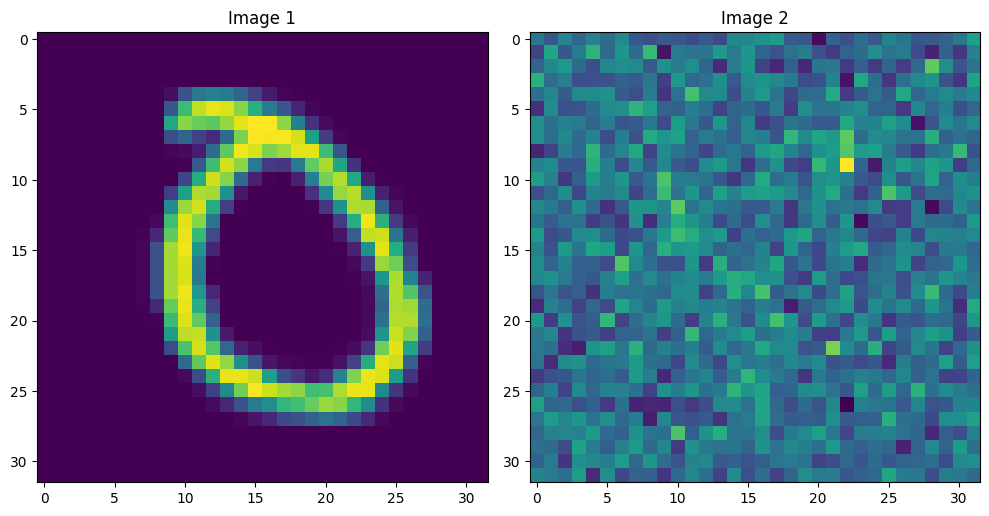

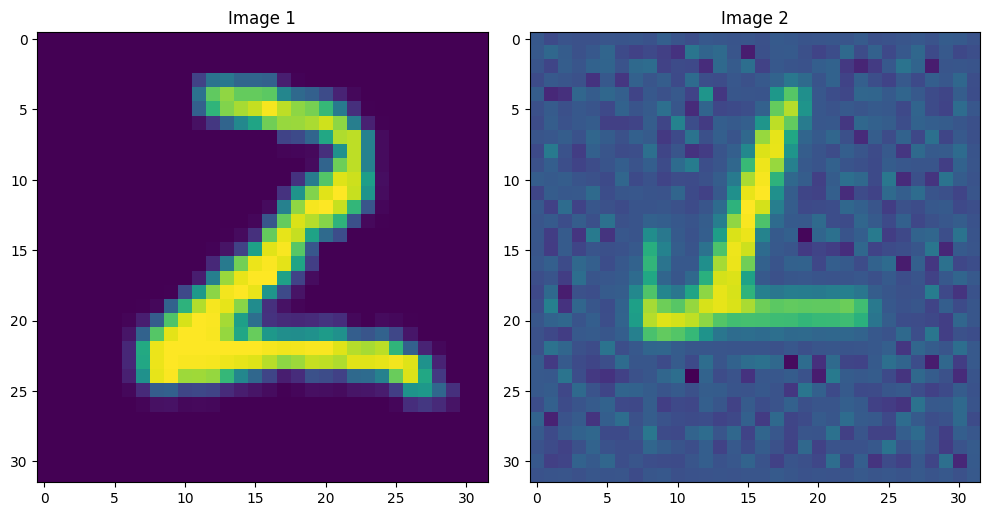

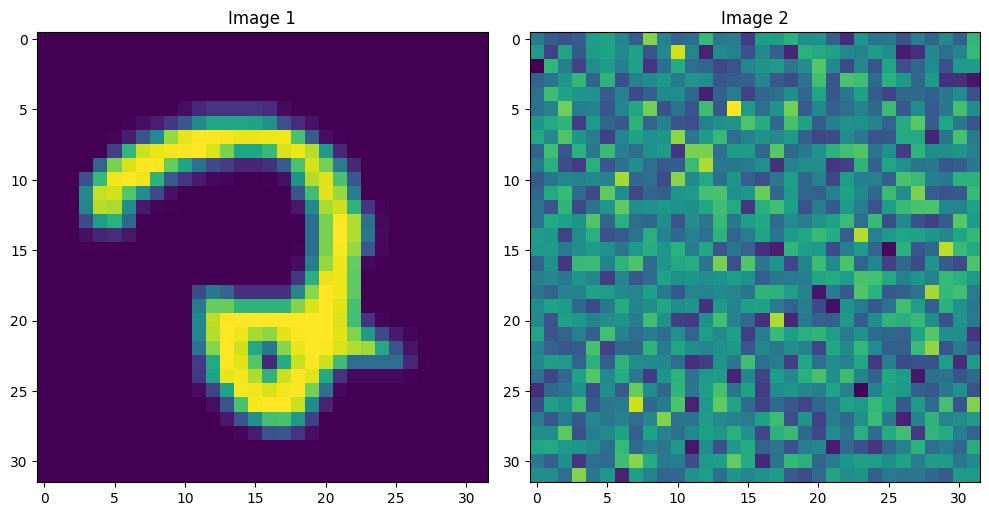

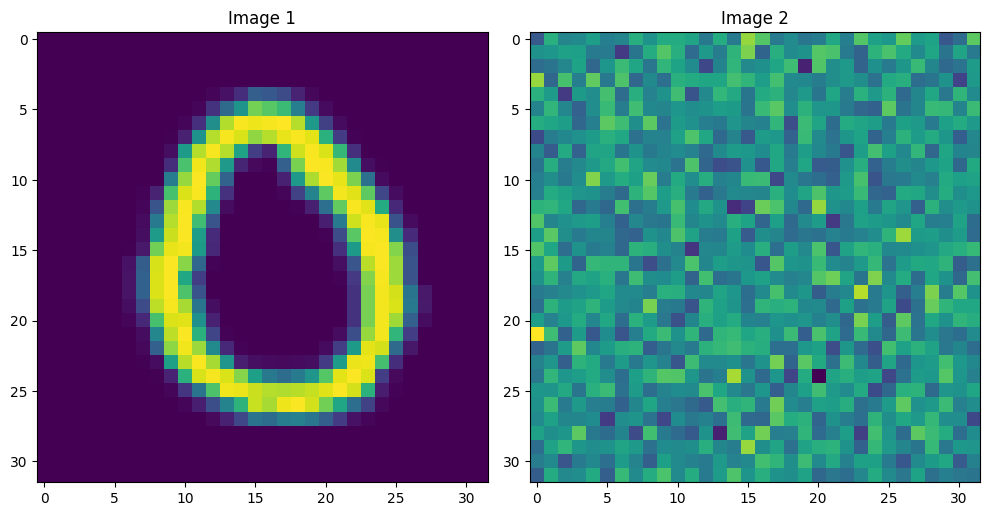

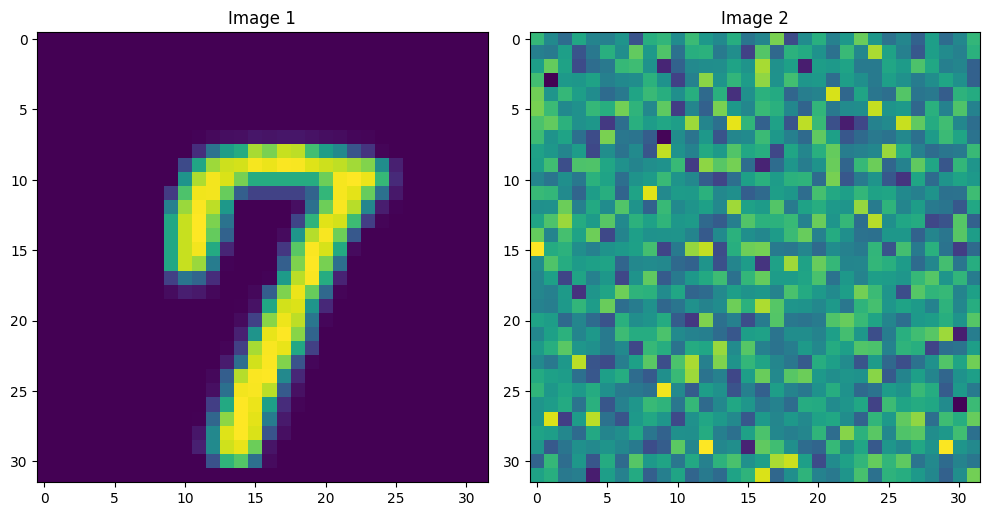

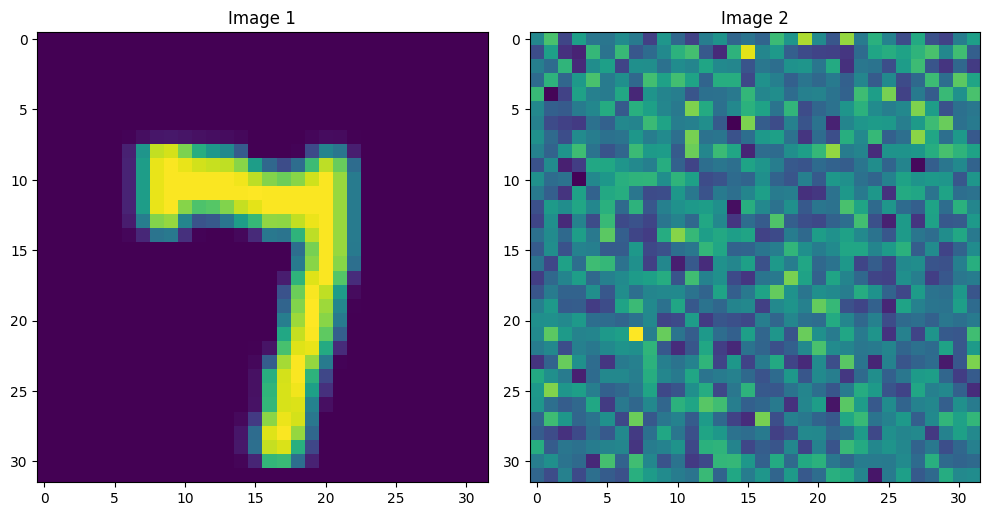

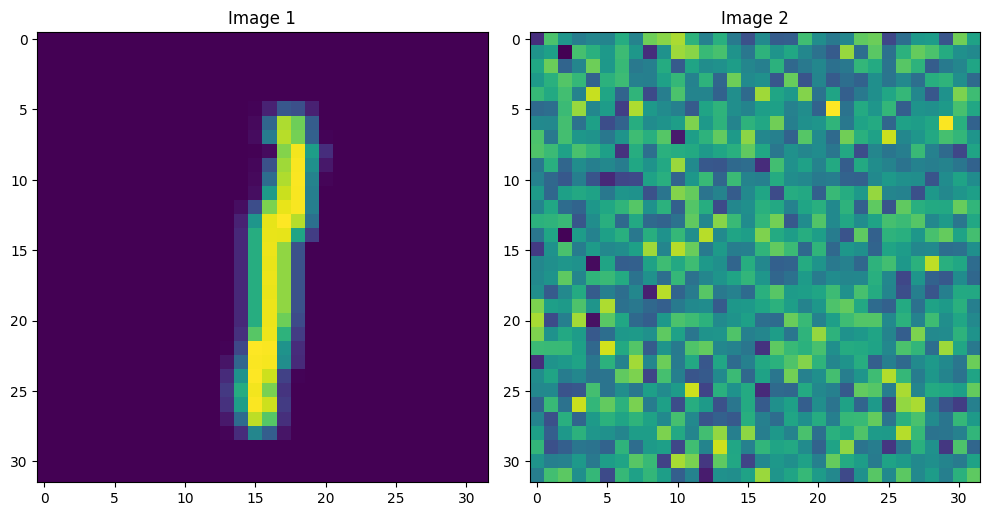

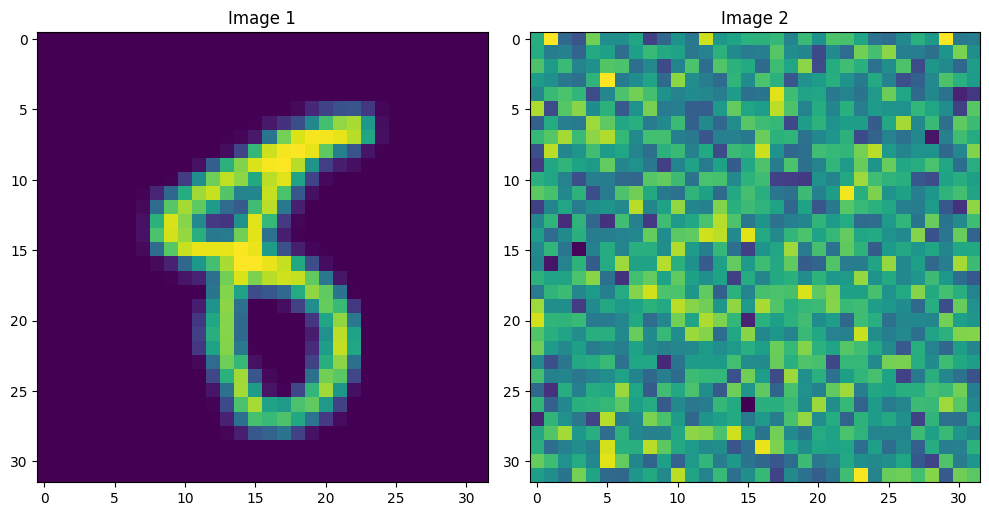

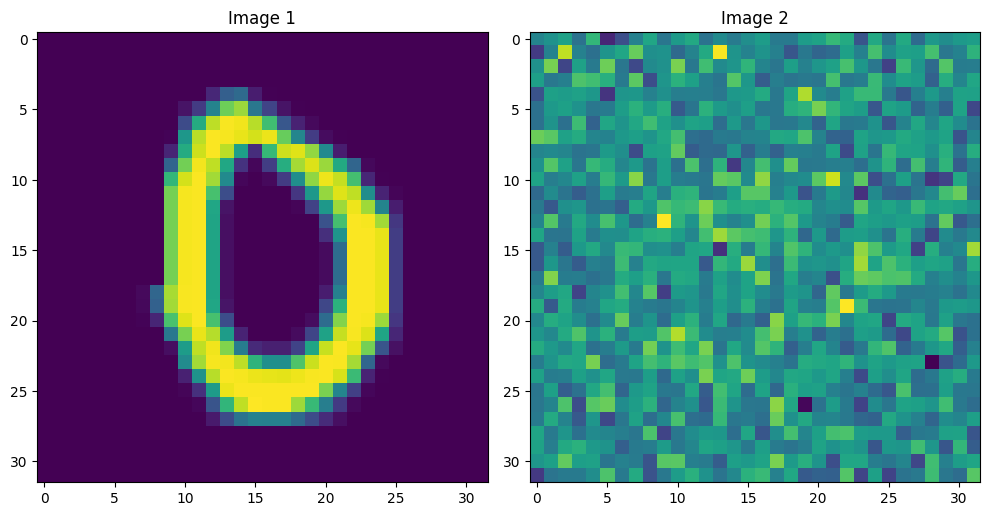

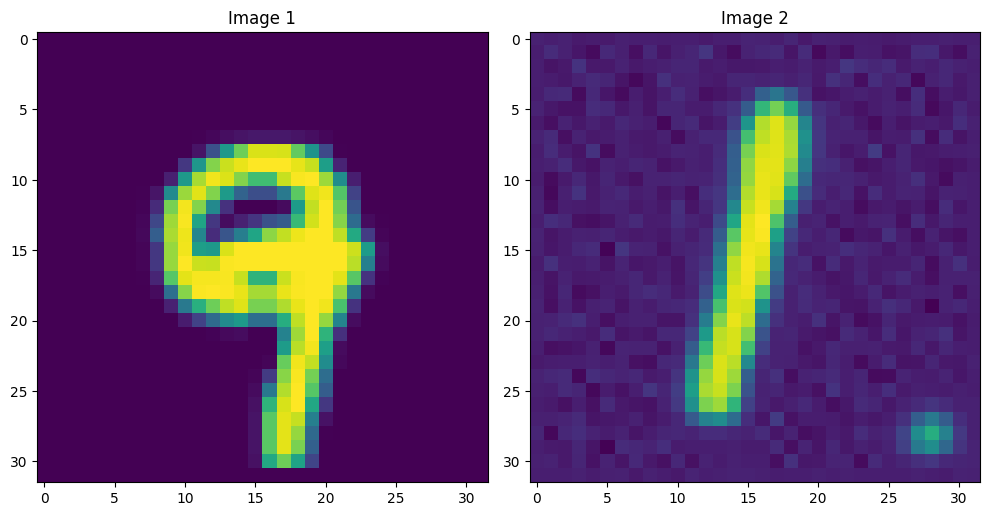

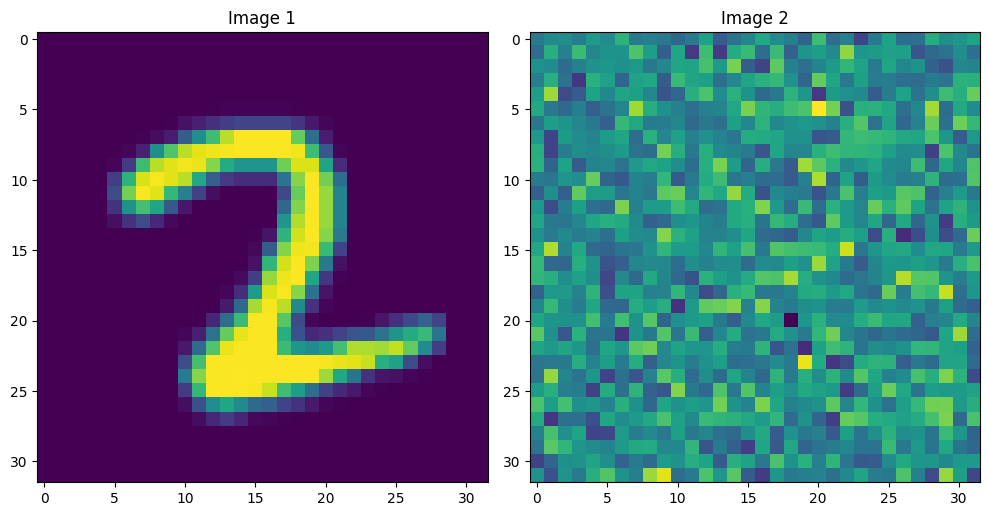

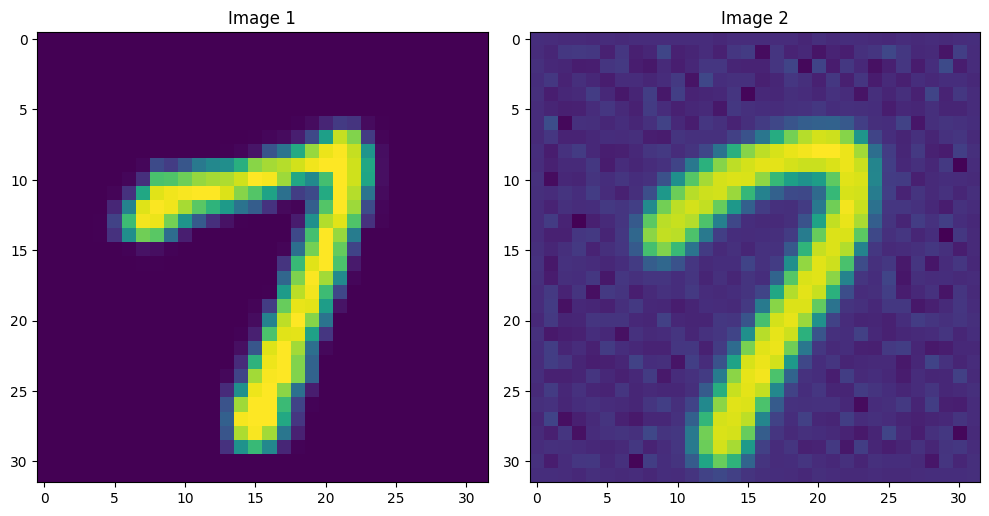

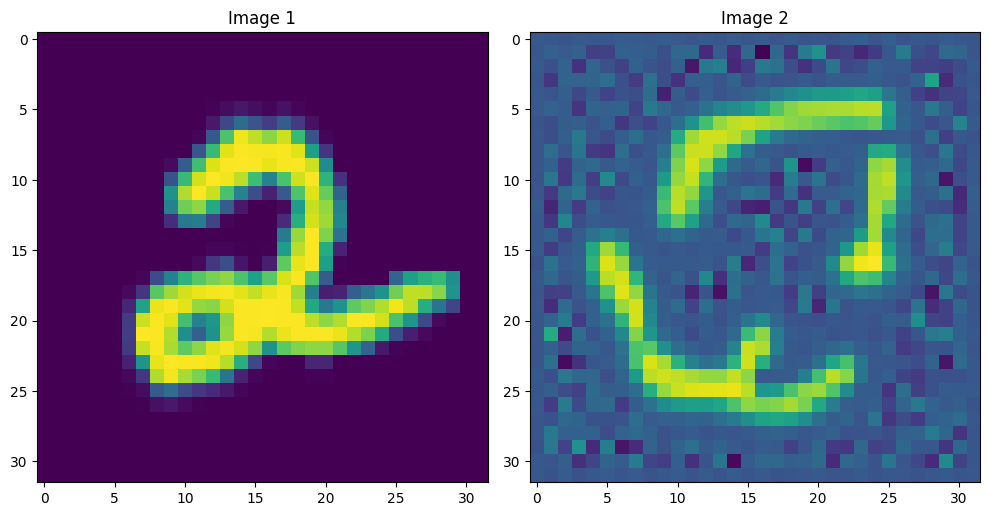

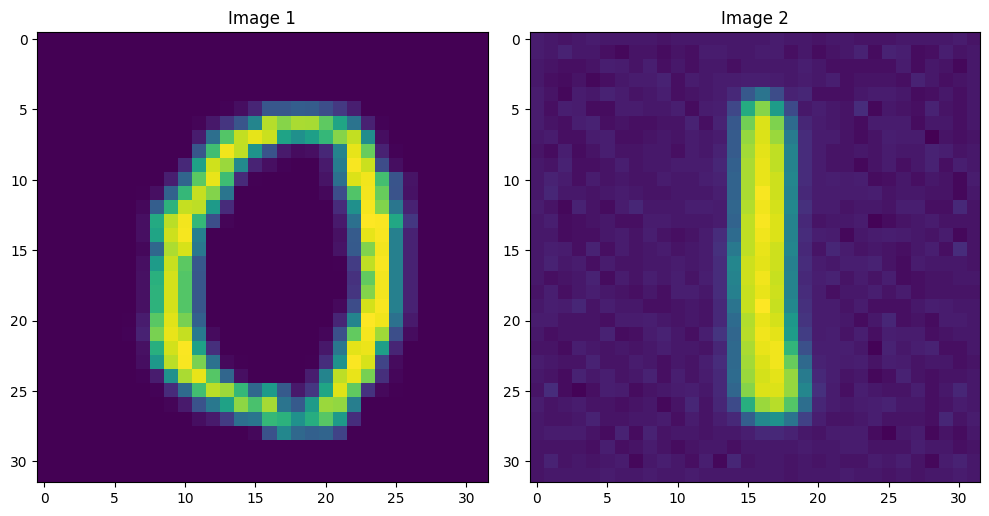

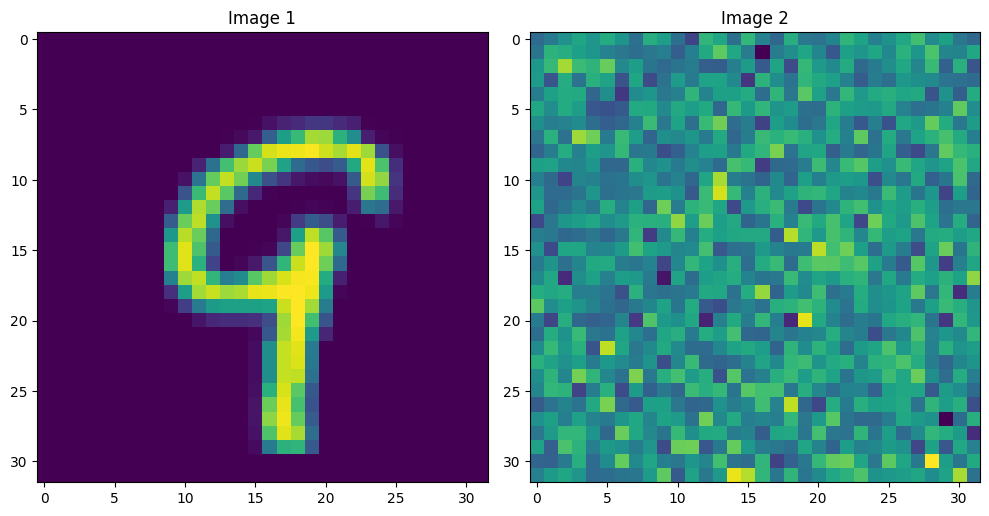

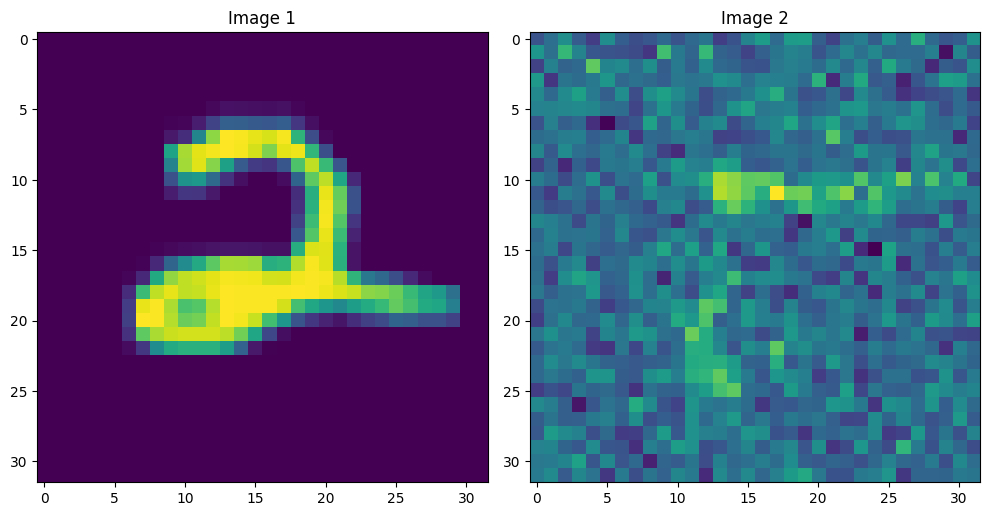

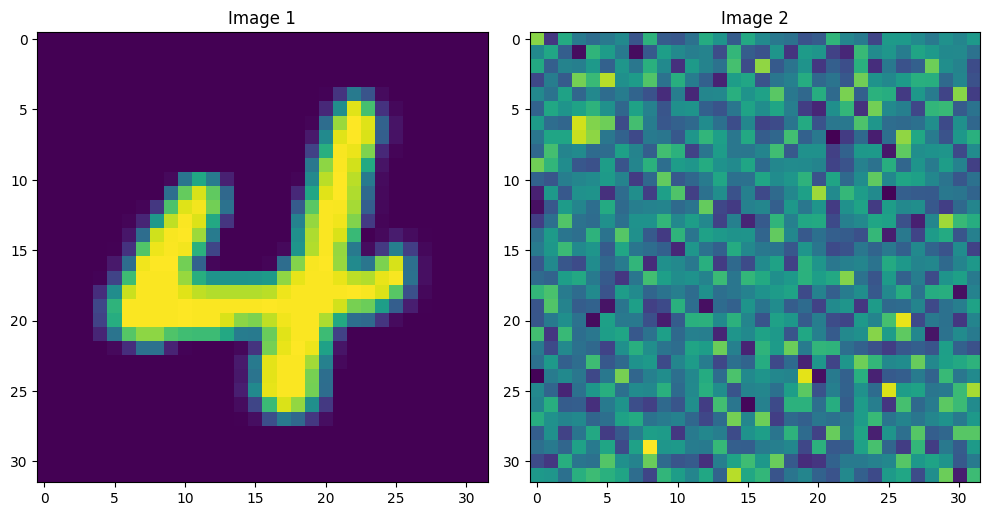

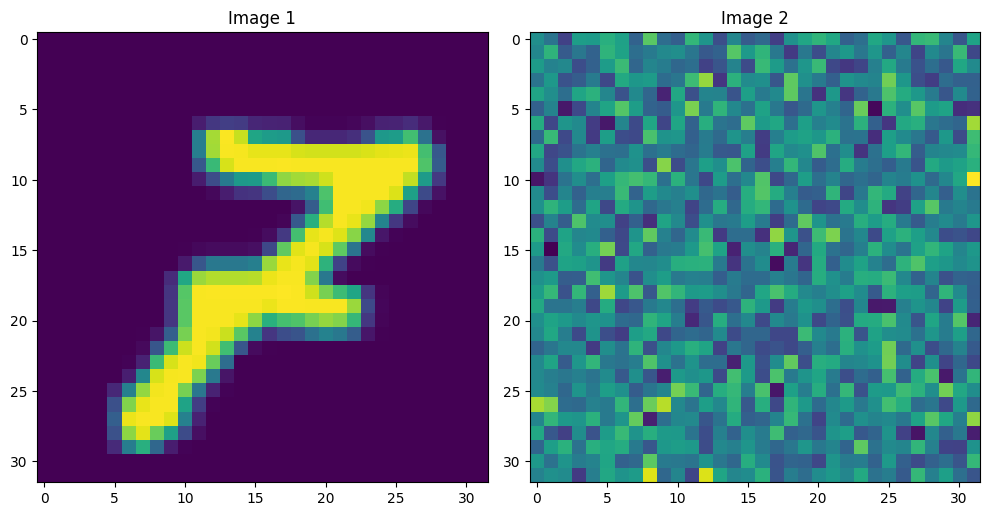

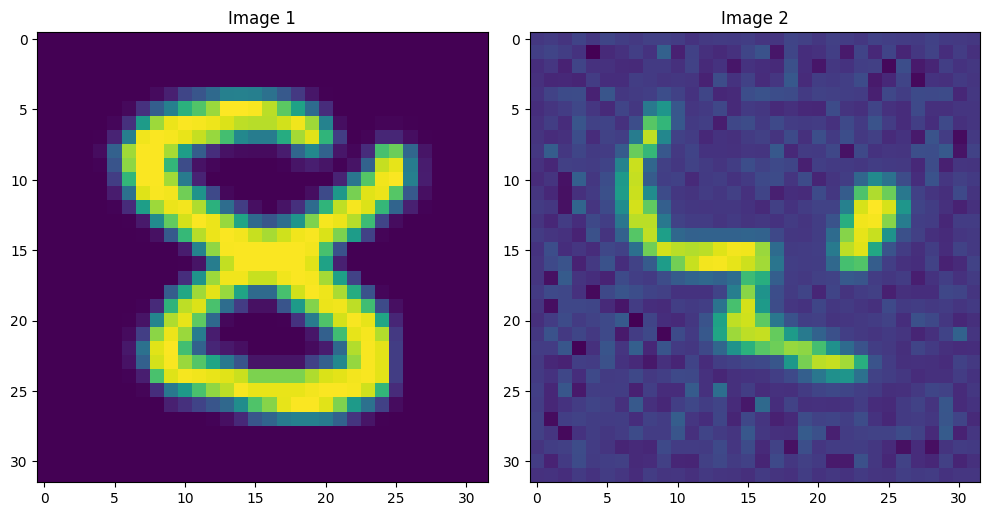

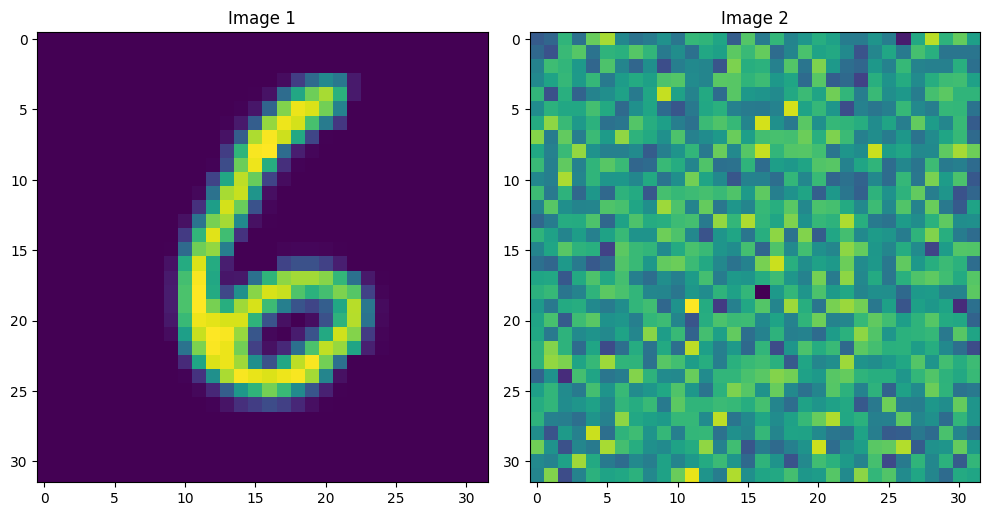

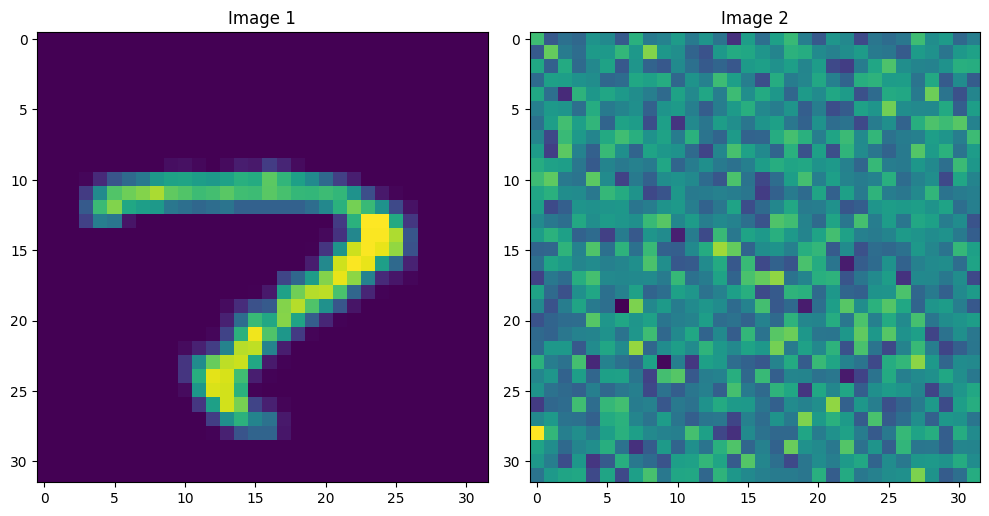

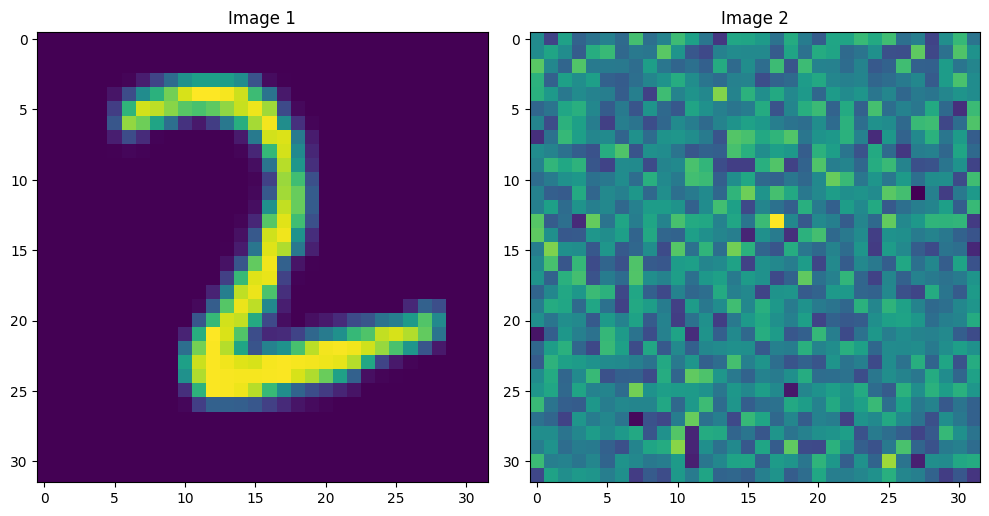

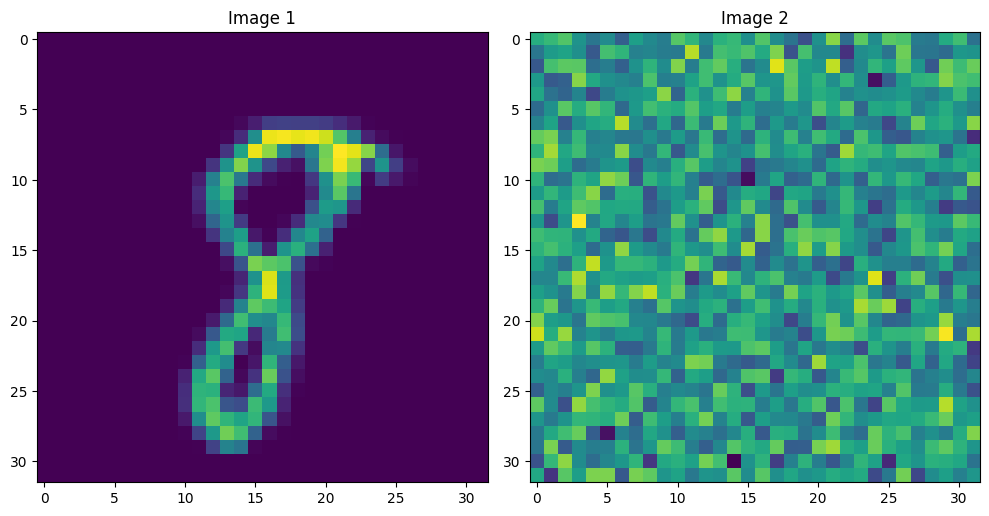

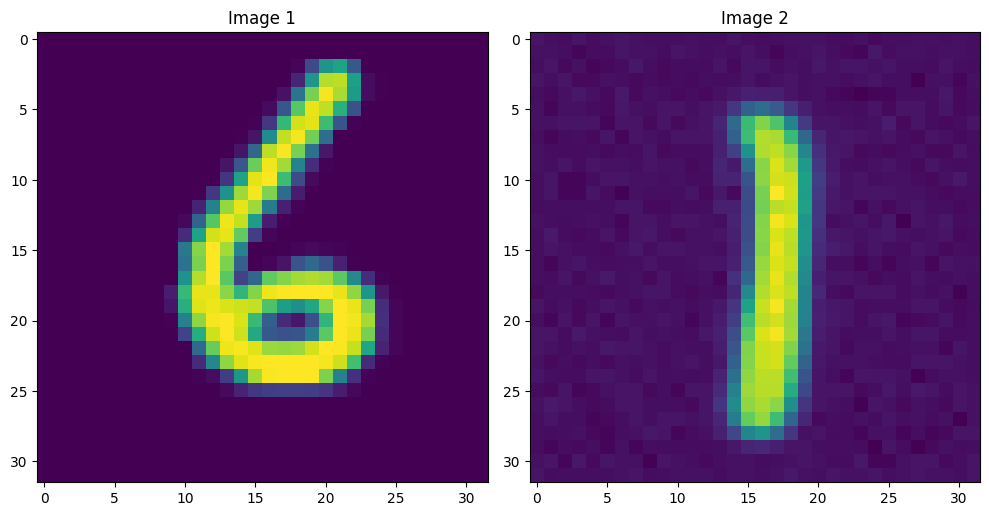

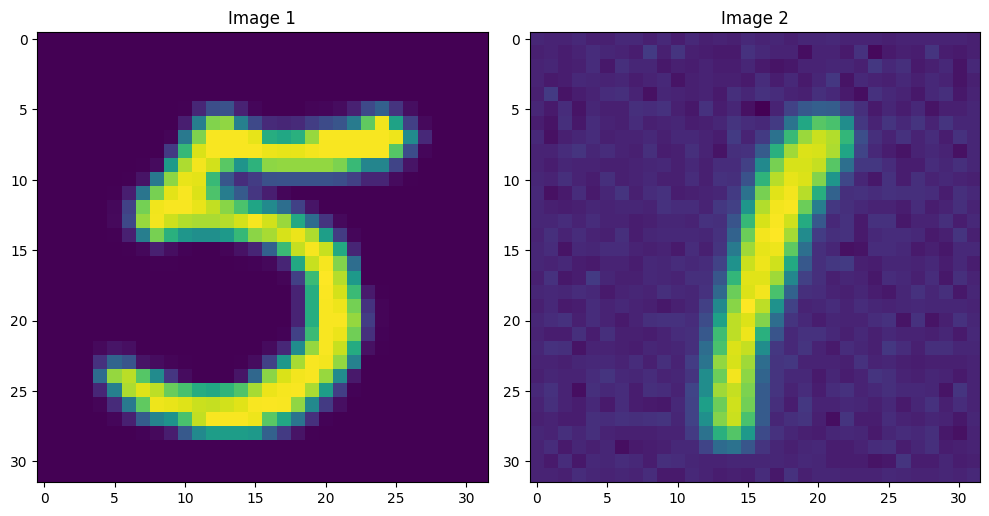

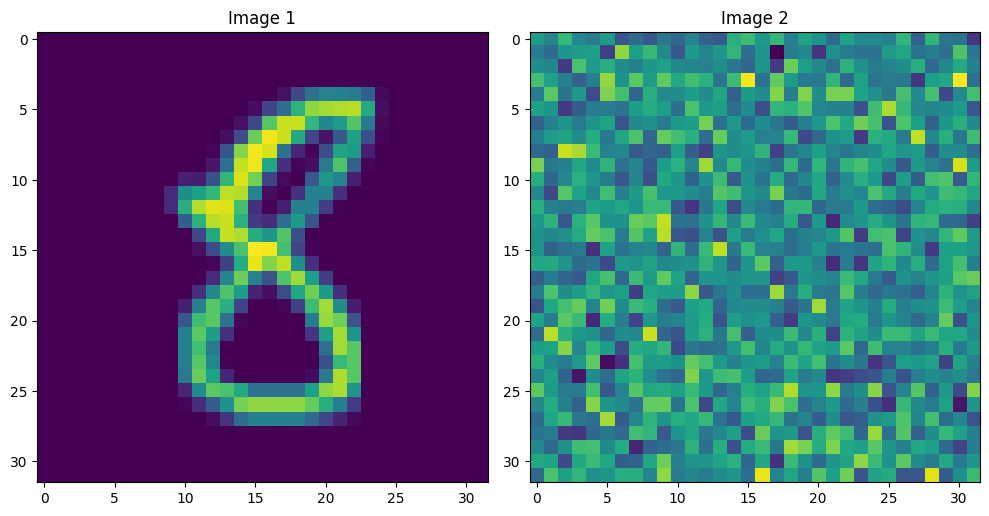

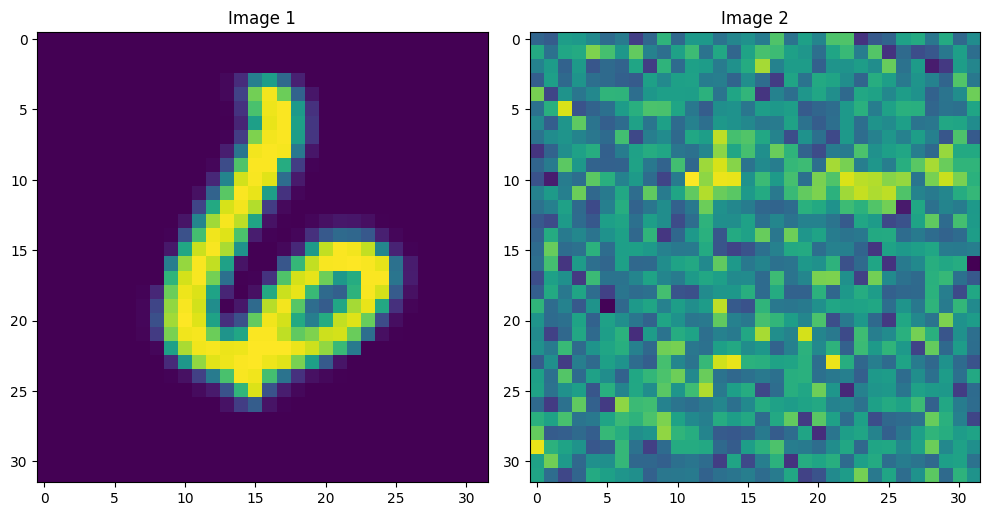

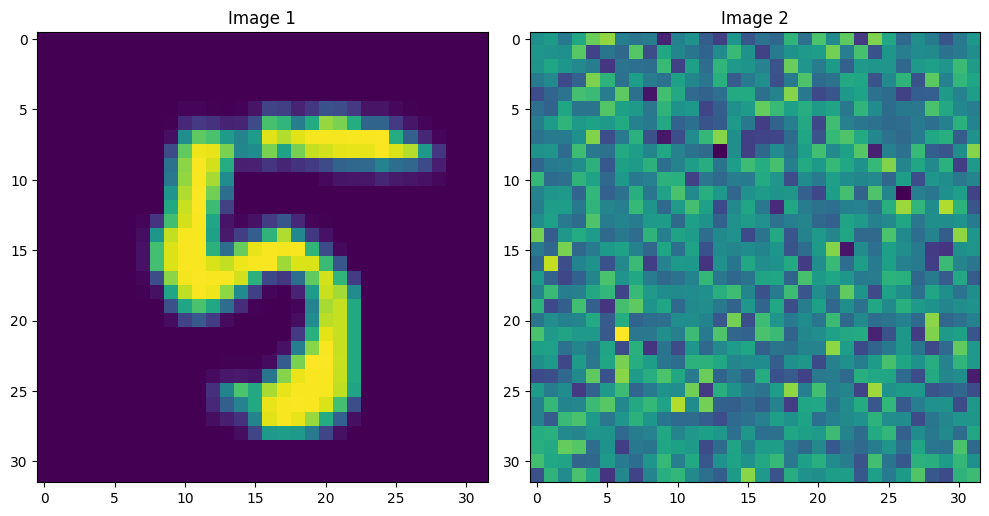

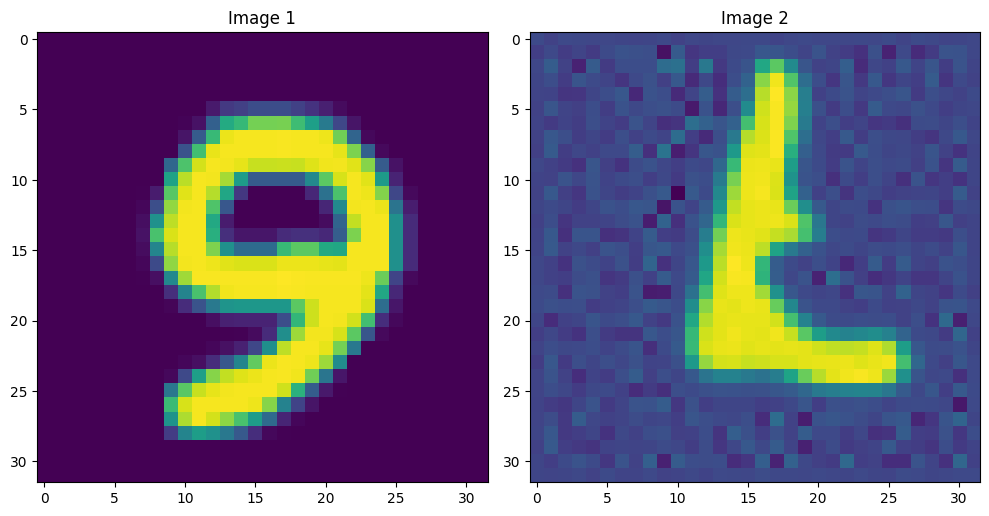

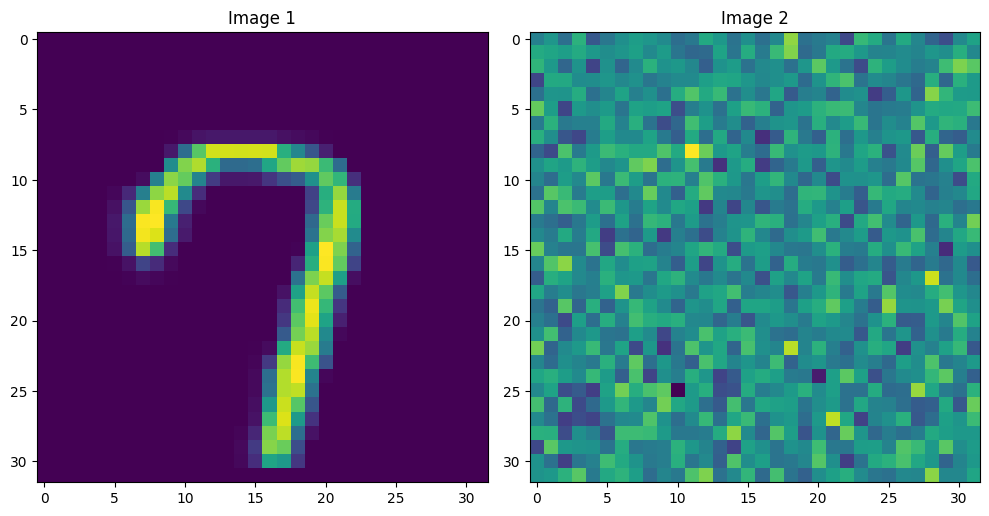

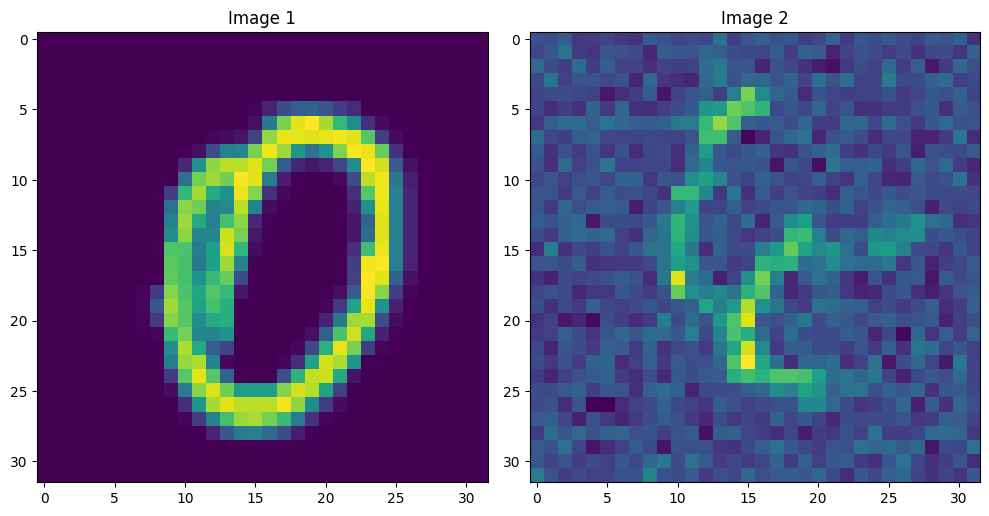

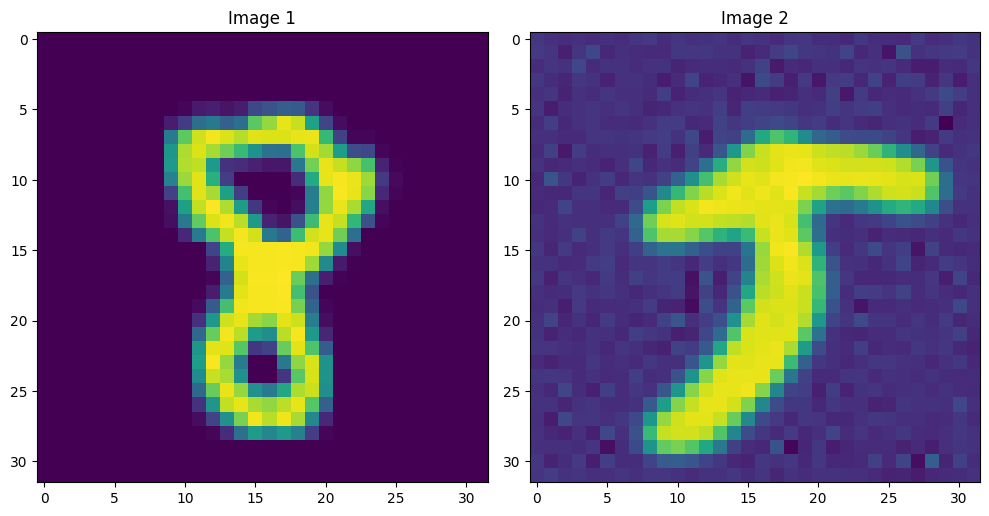

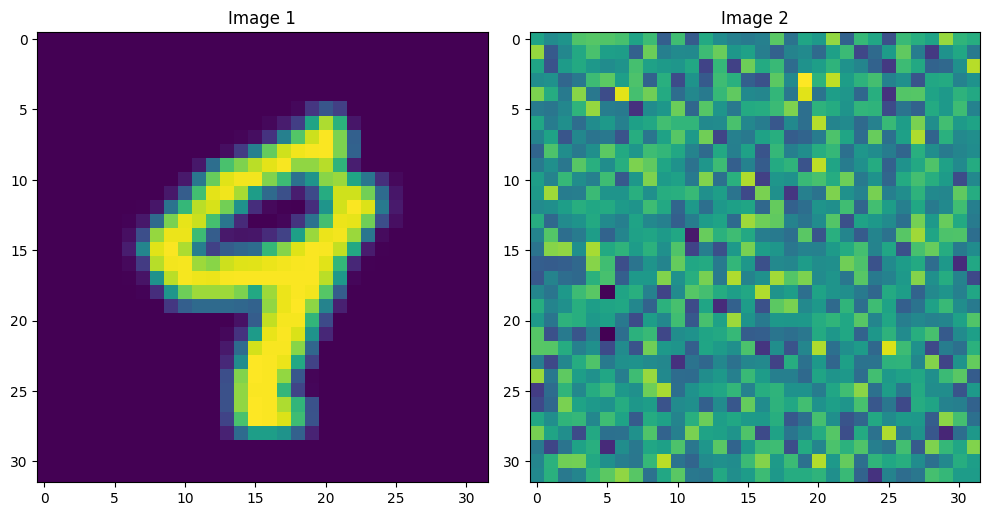

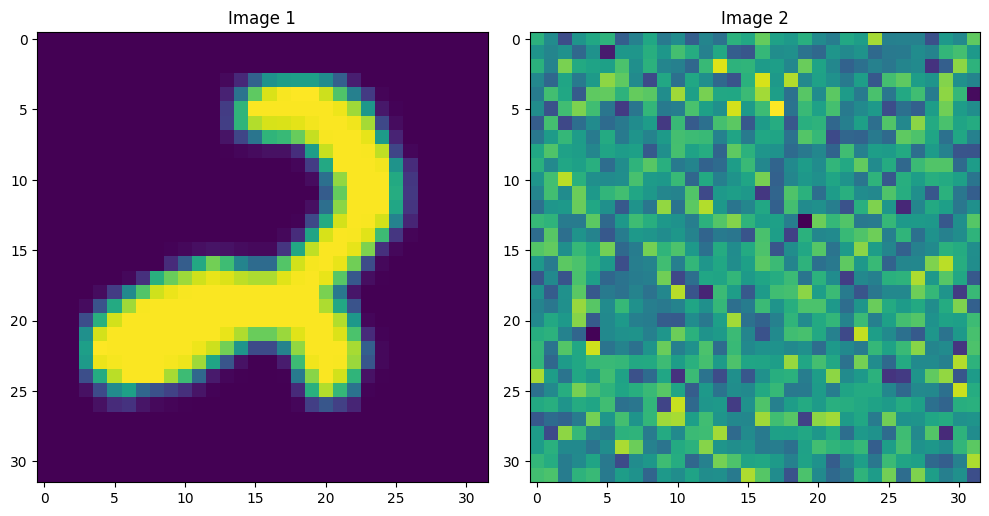

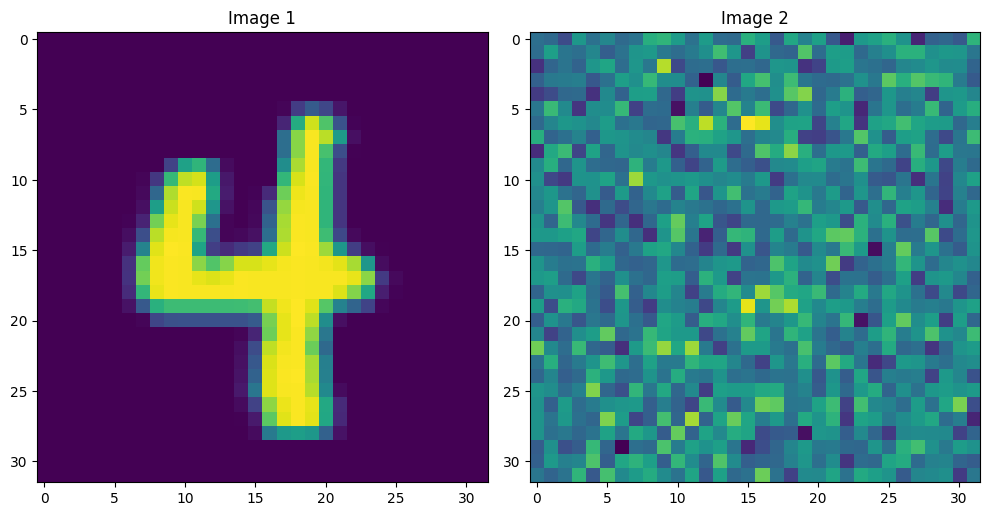

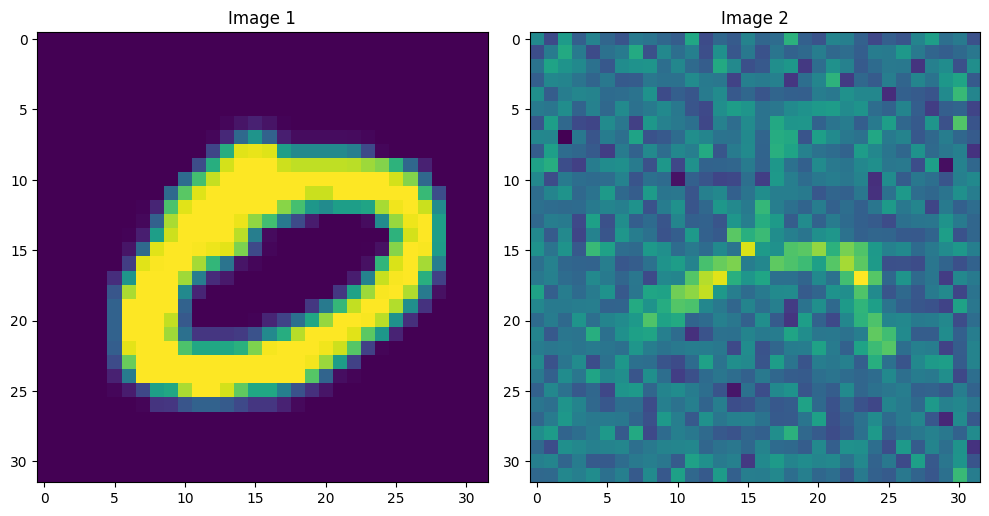

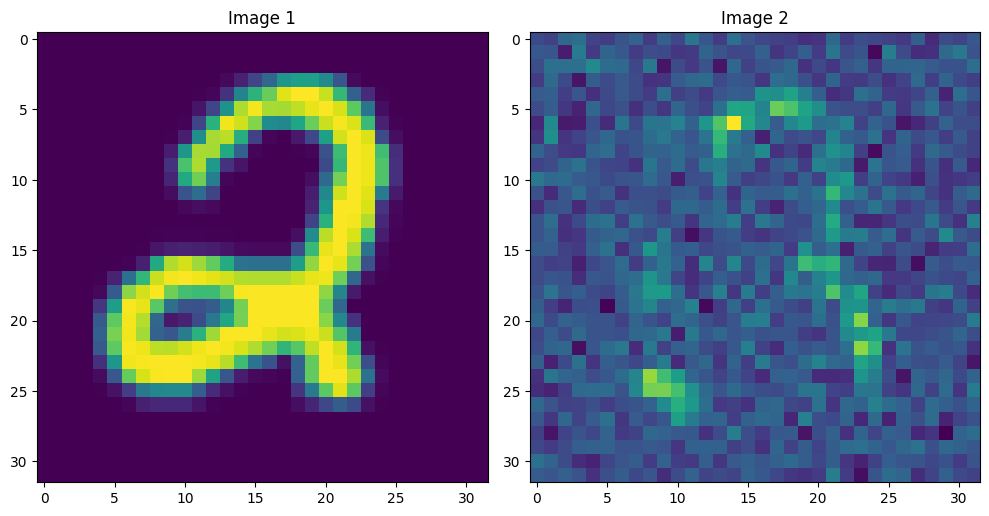

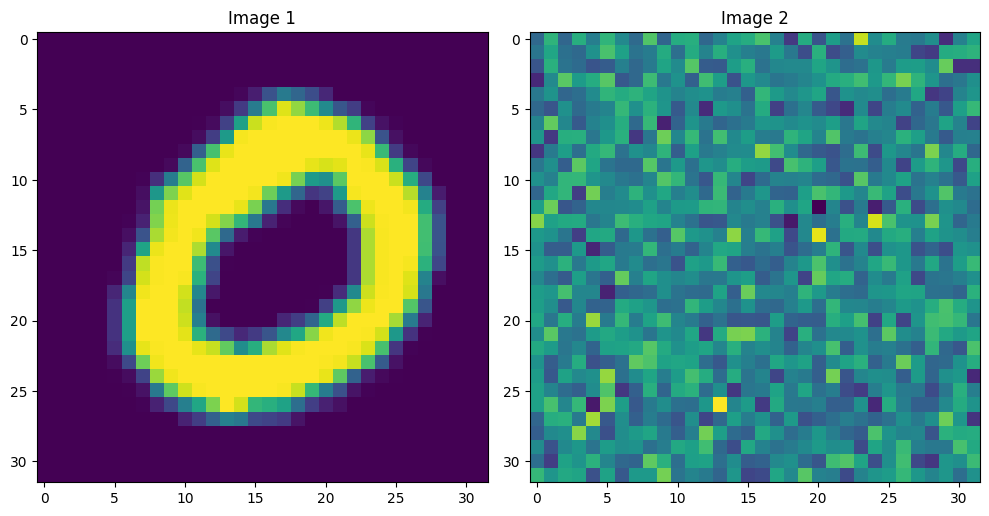

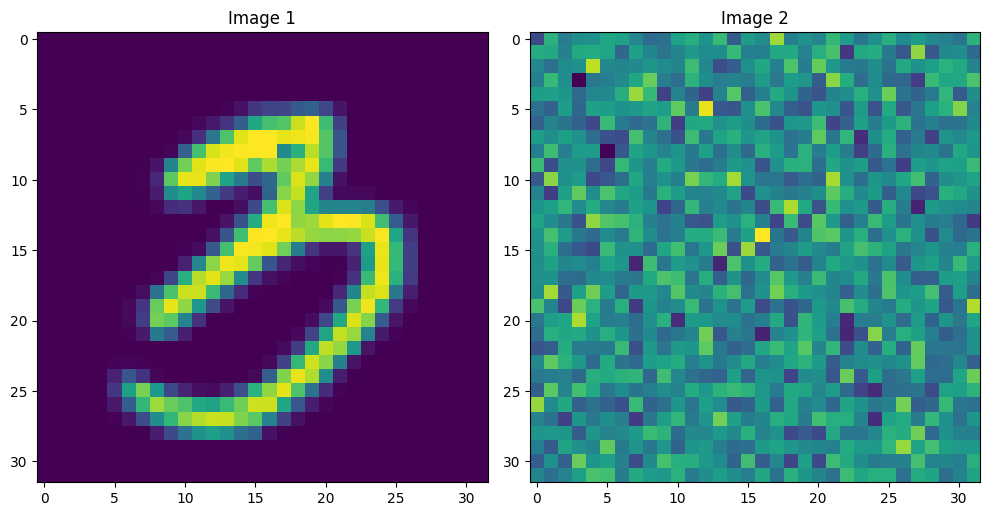

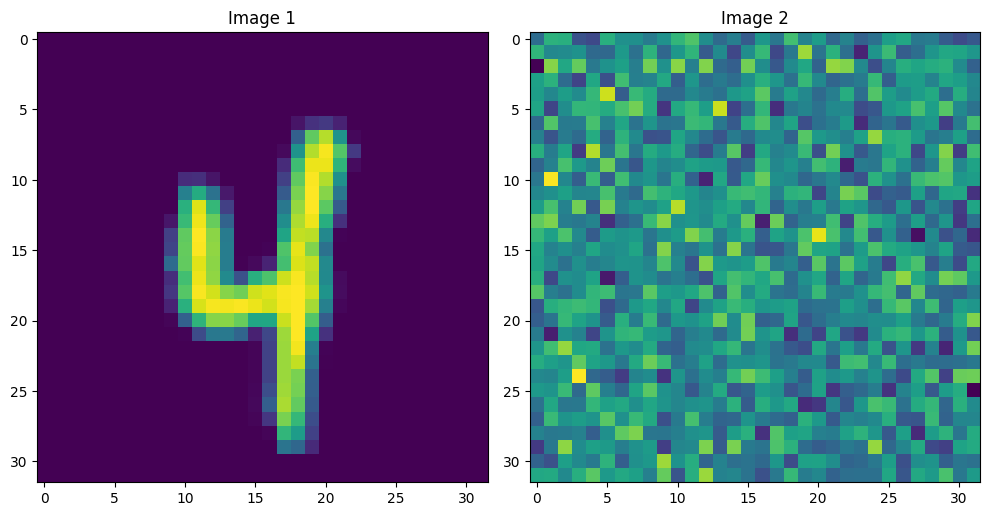

In [85]:
print_result(result_DDPM)

In [94]:
result_DDIM = model.evaluate(num=5,
                        sampling_type='DDIM',
                        n_jumps=100)
# [num, 3, B, 1, 32, 32]

  0%|          | 4/1250 [00:08<45:48,  2.21s/it]


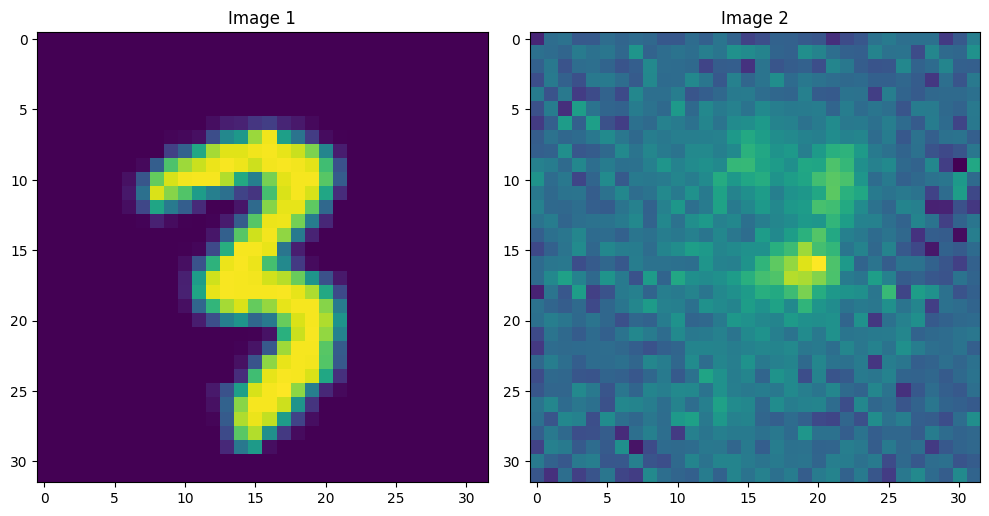

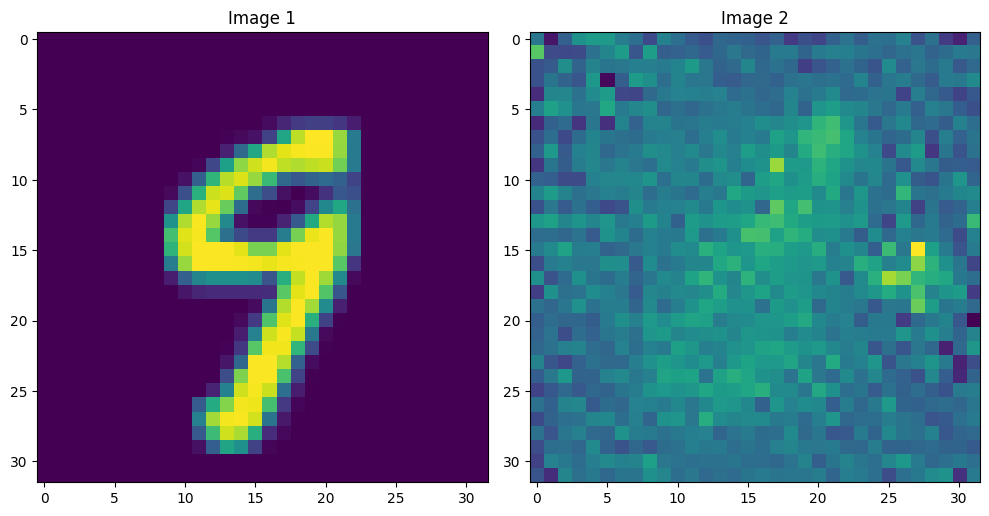

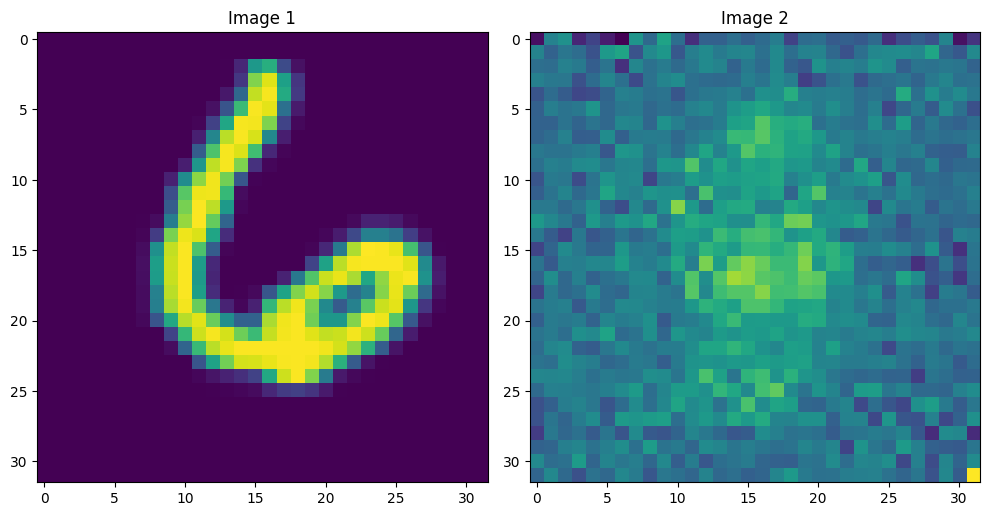

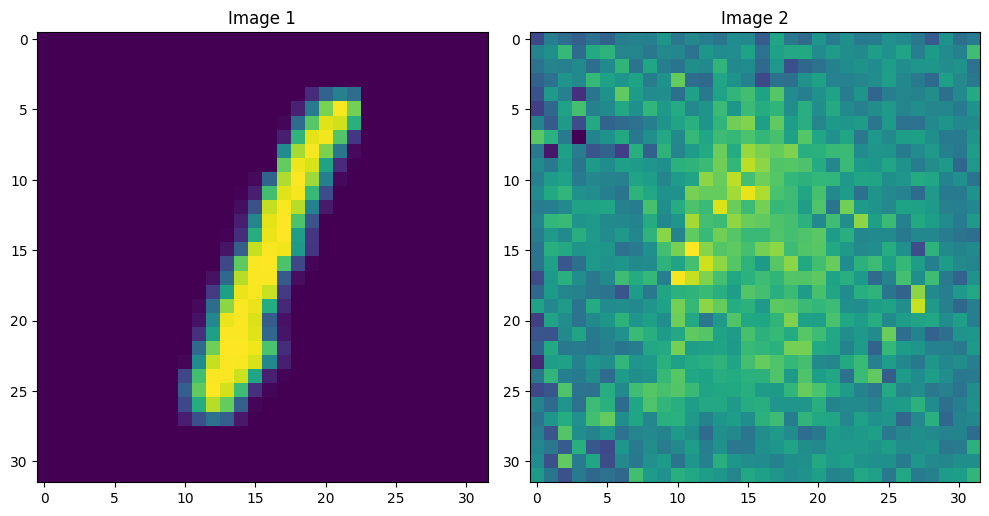

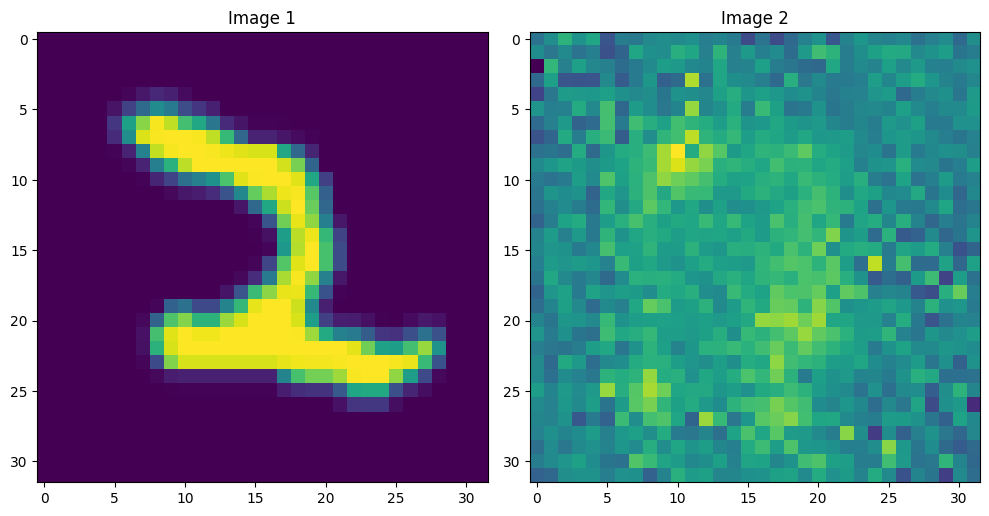

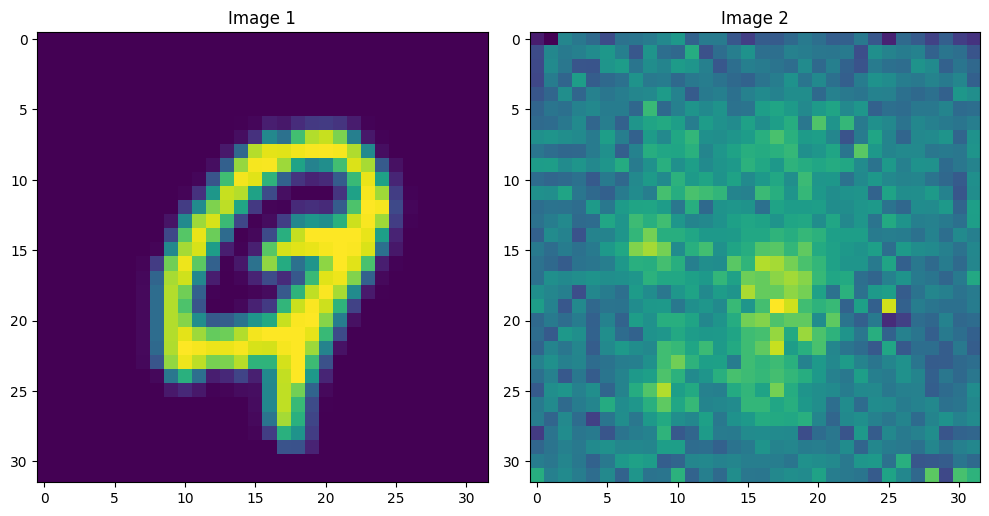

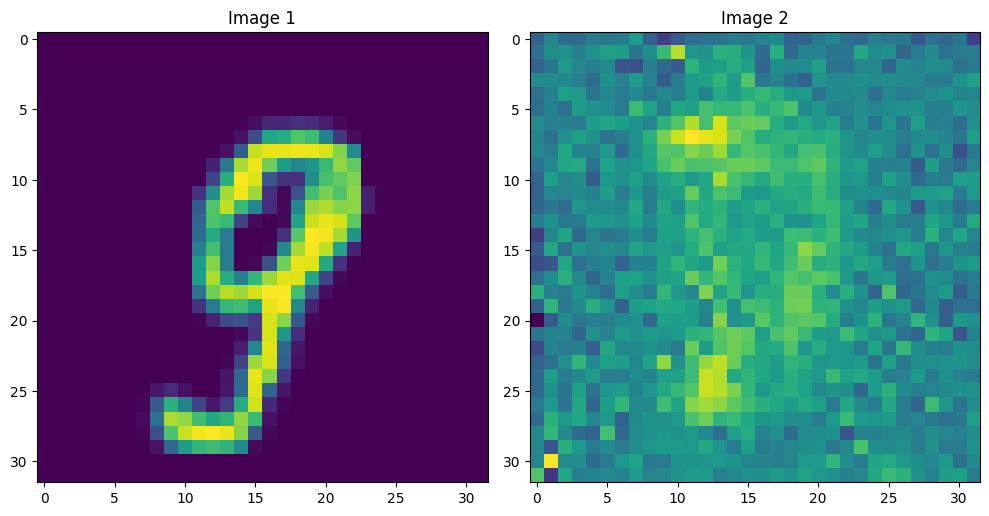

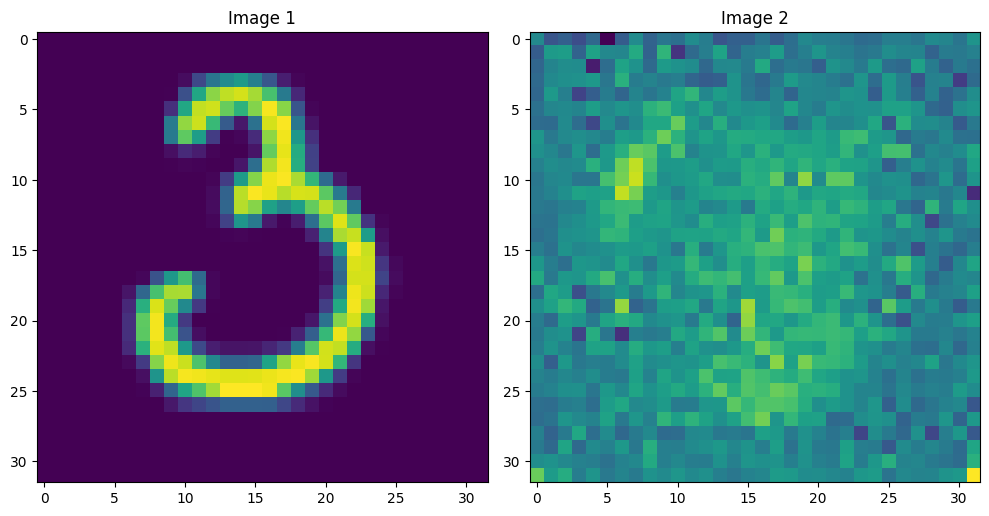

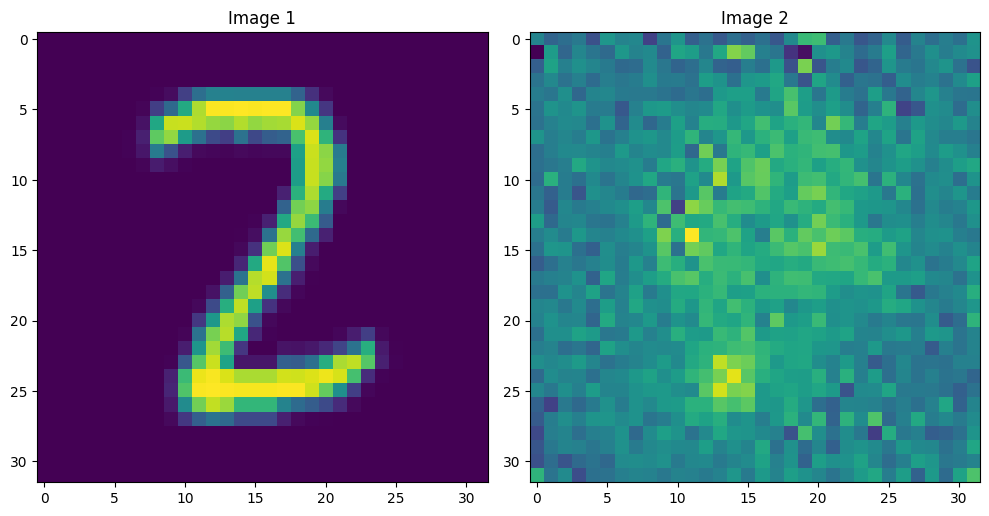

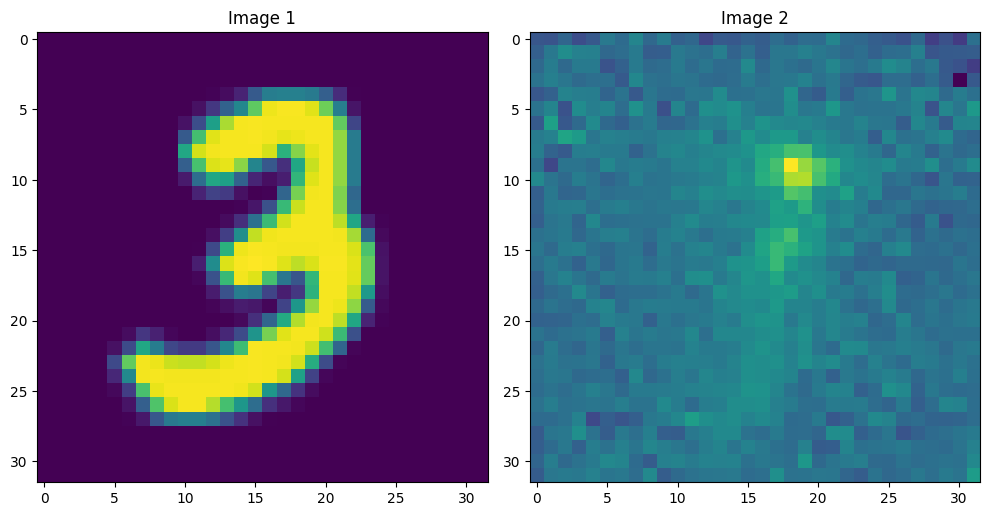

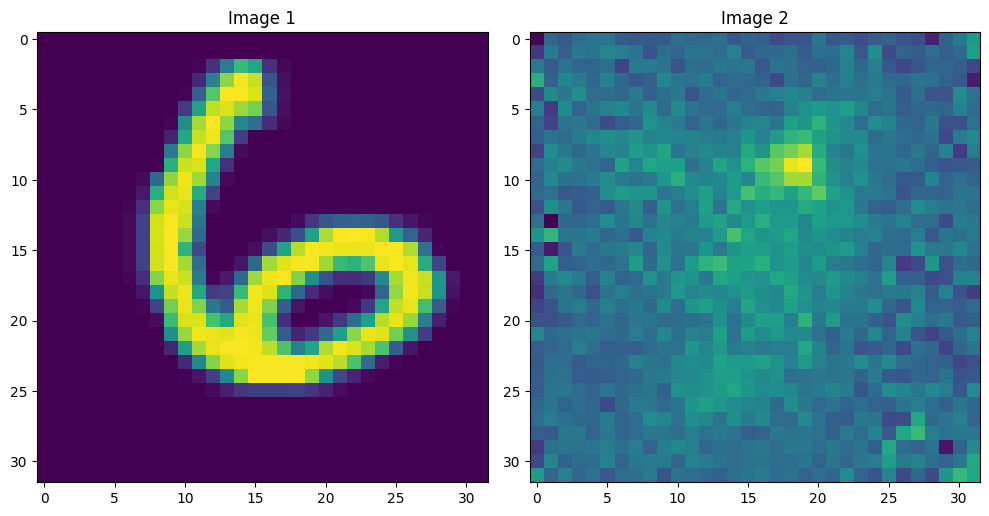

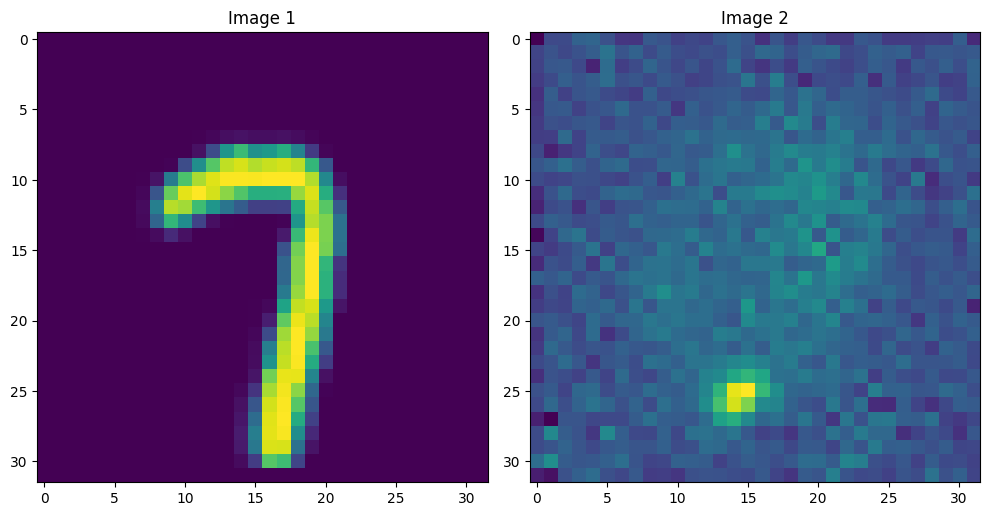

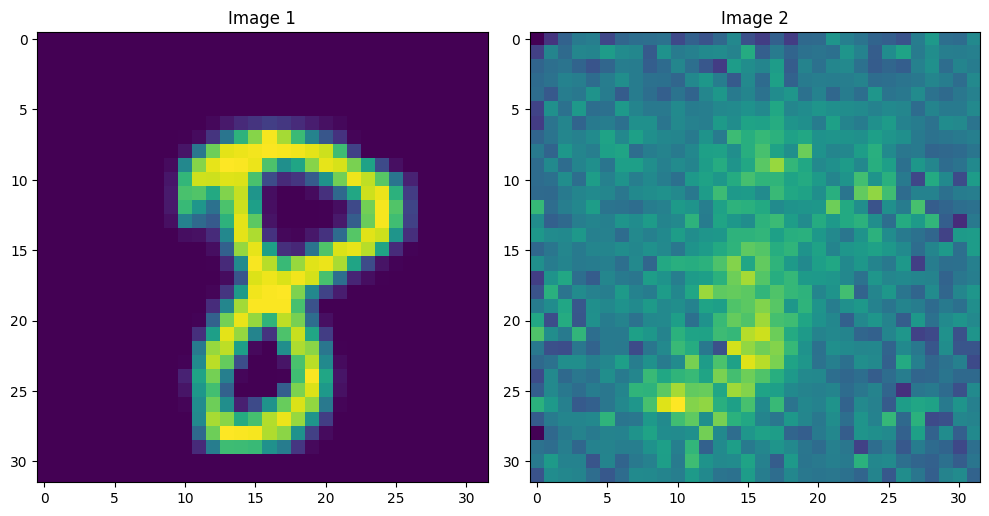

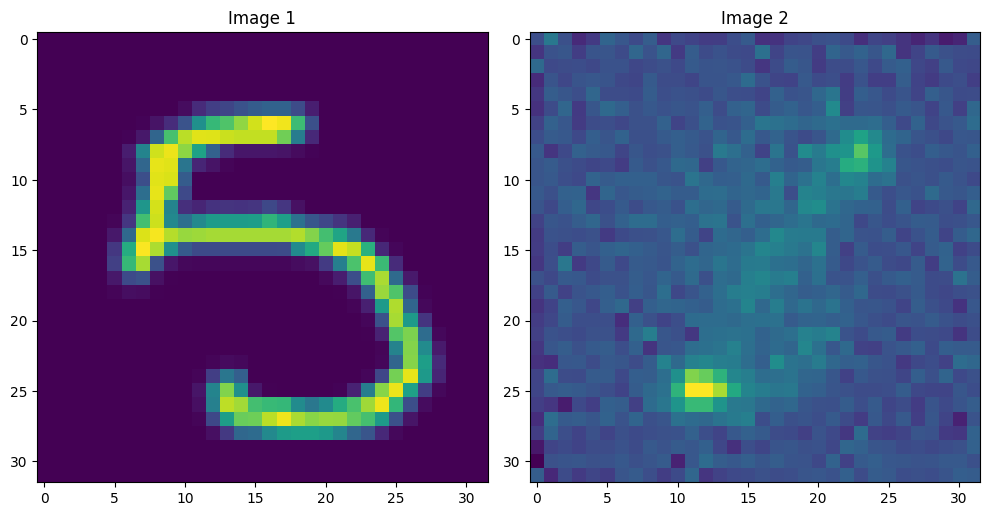

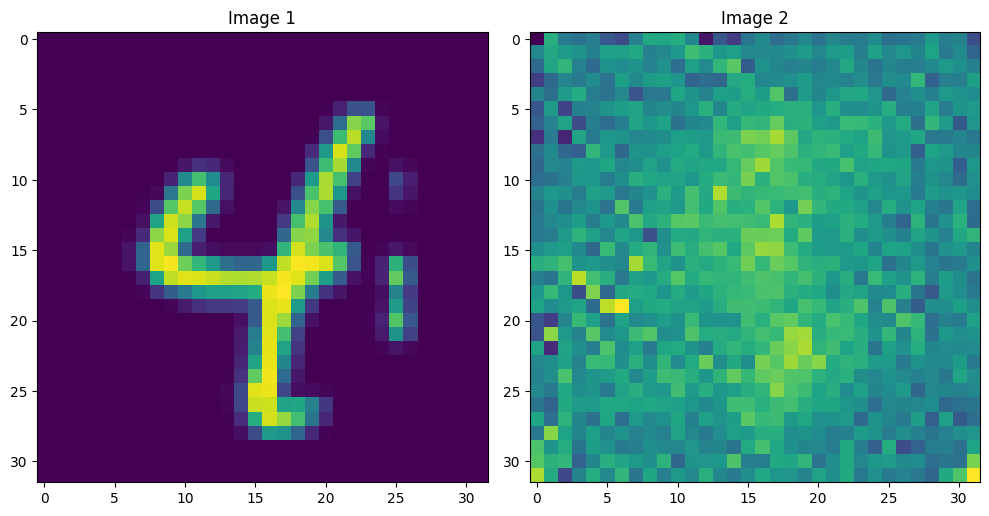

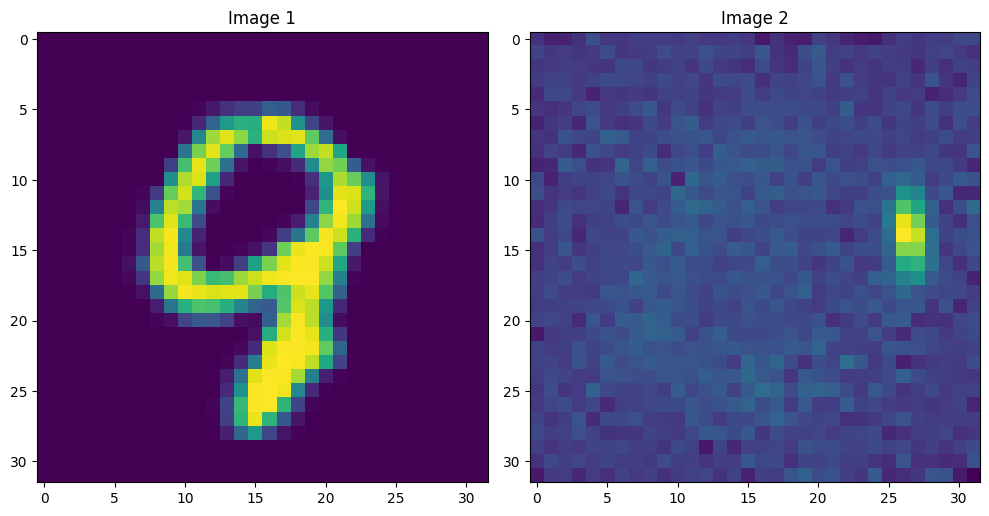

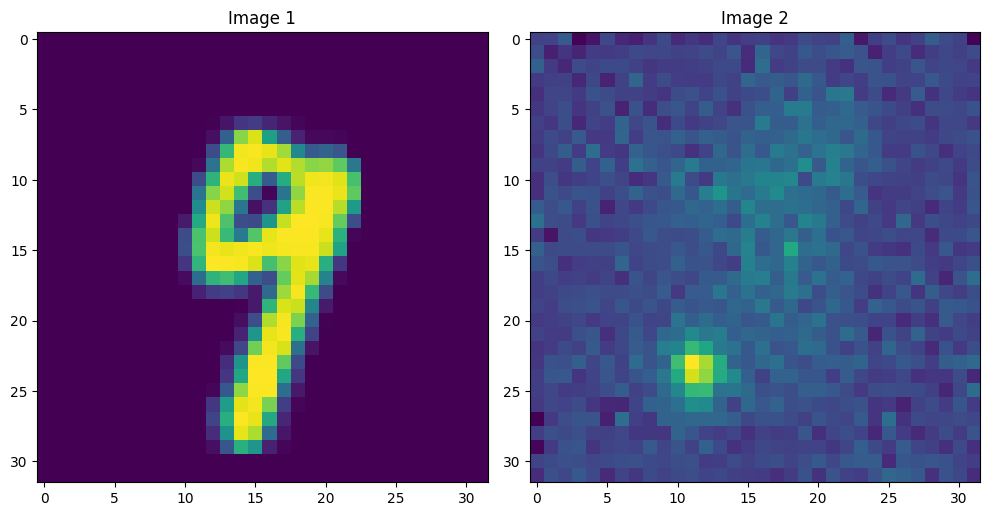

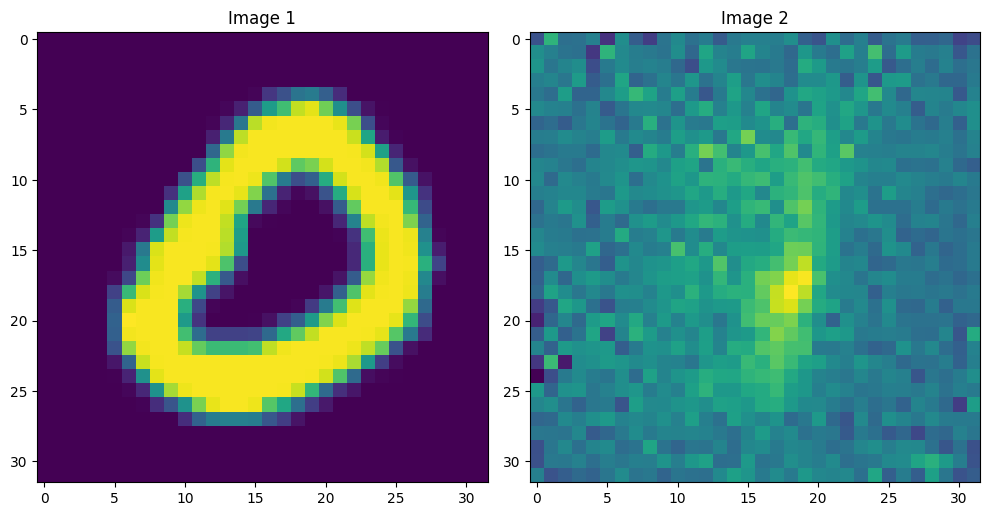

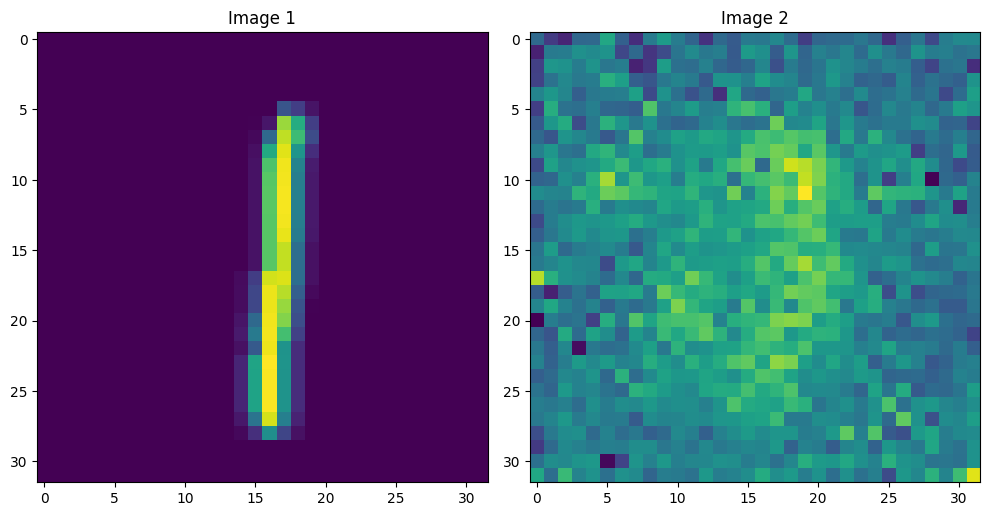

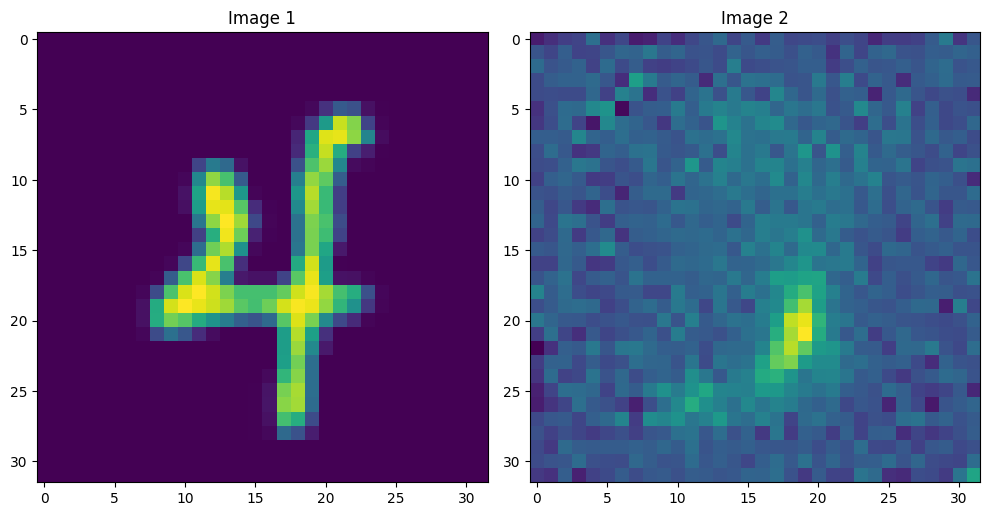

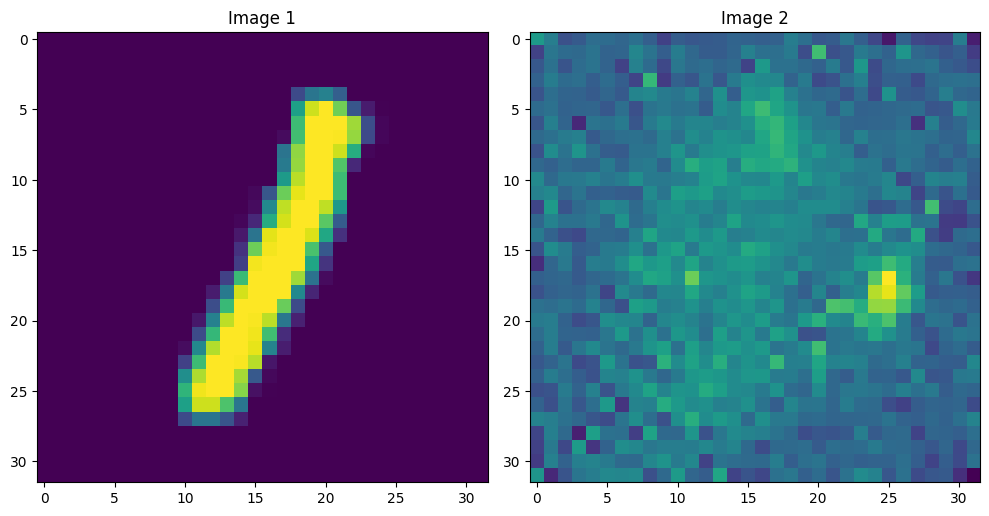

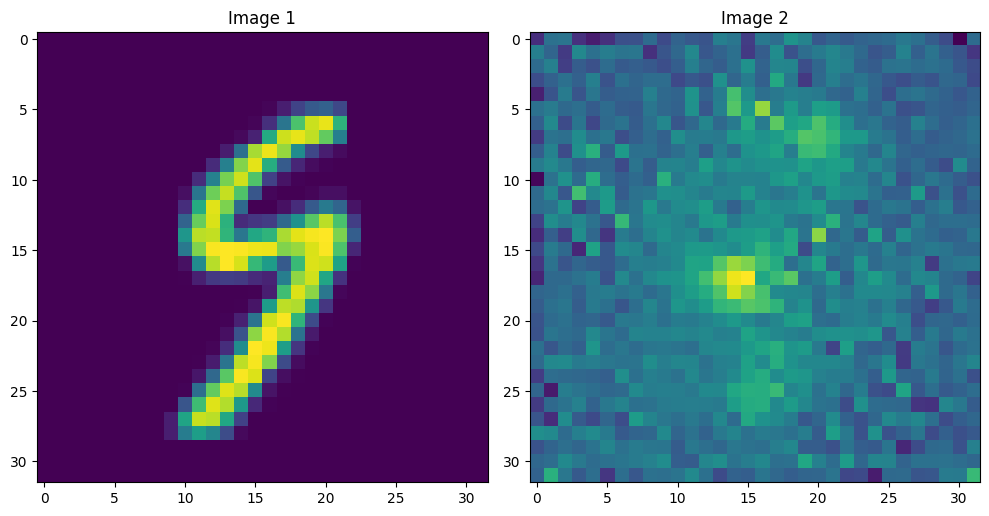

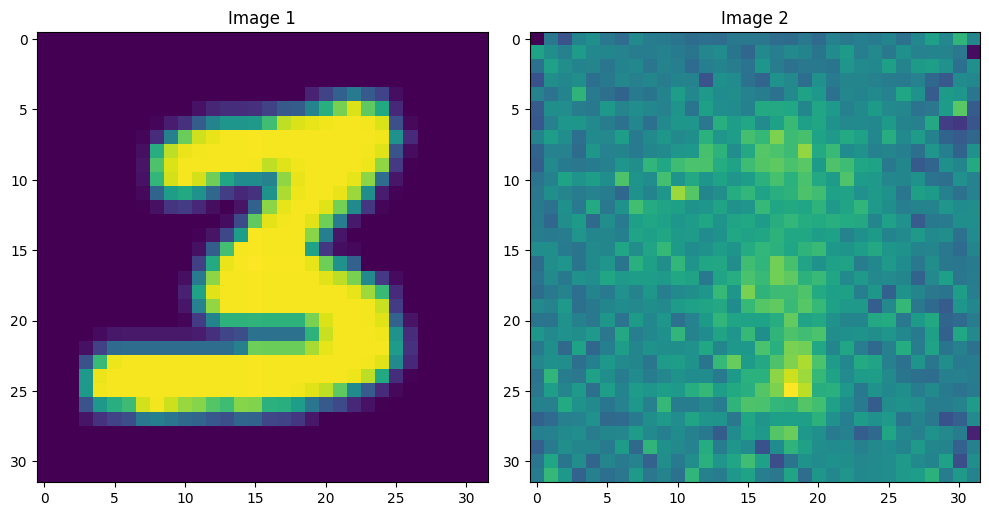

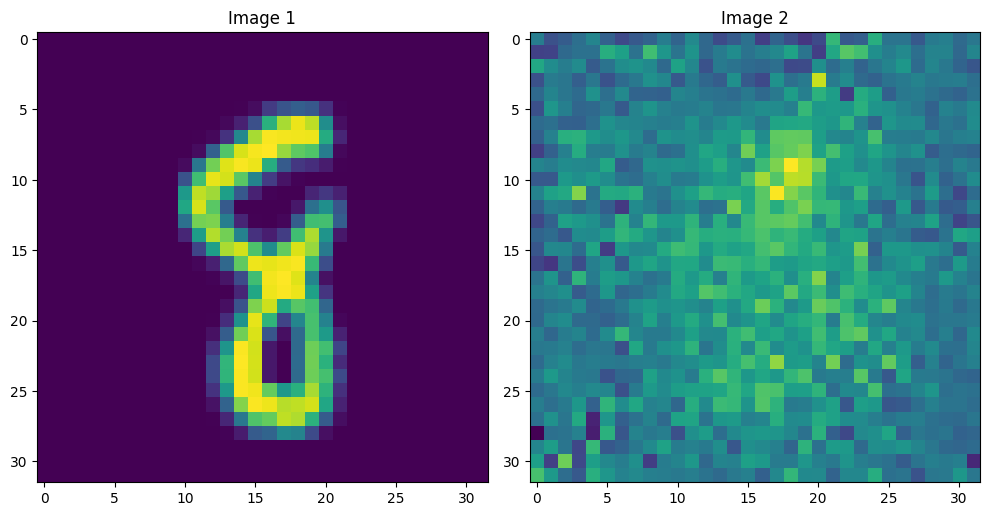

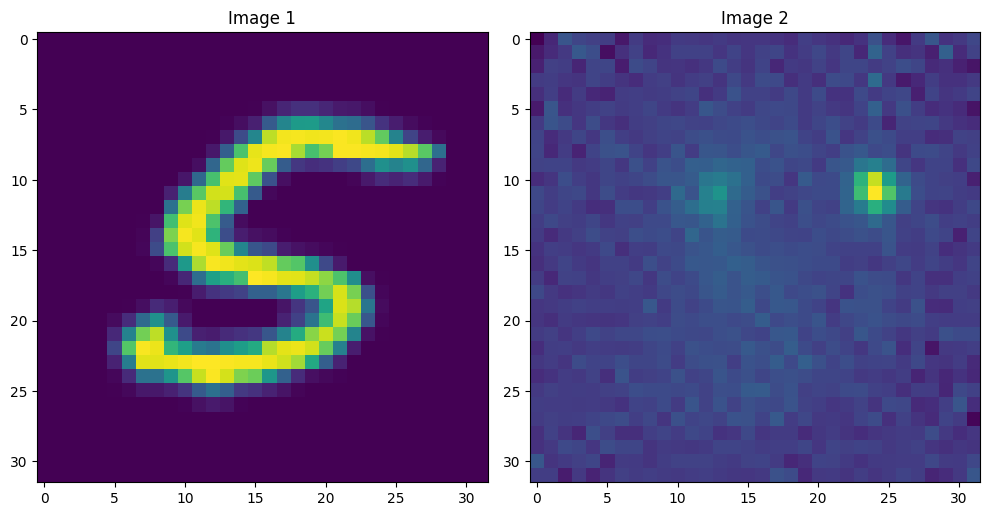

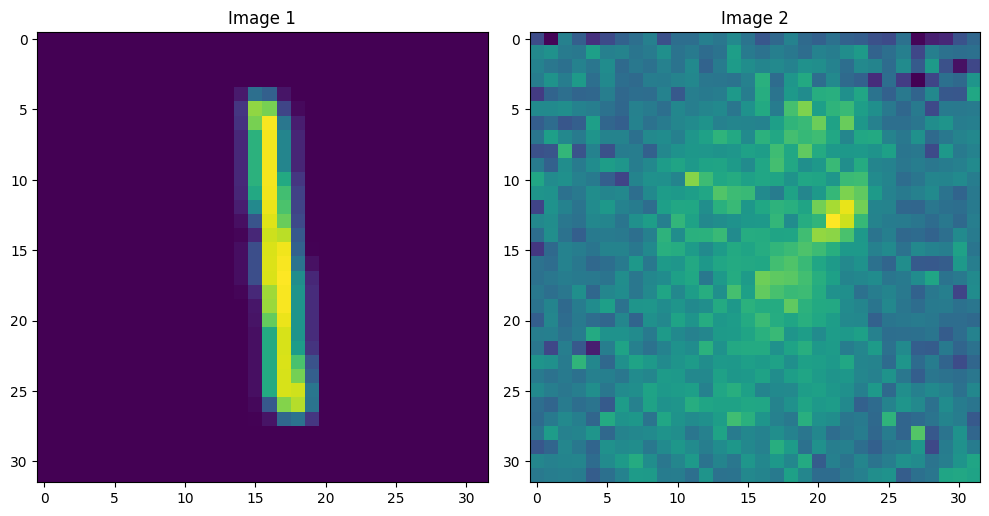

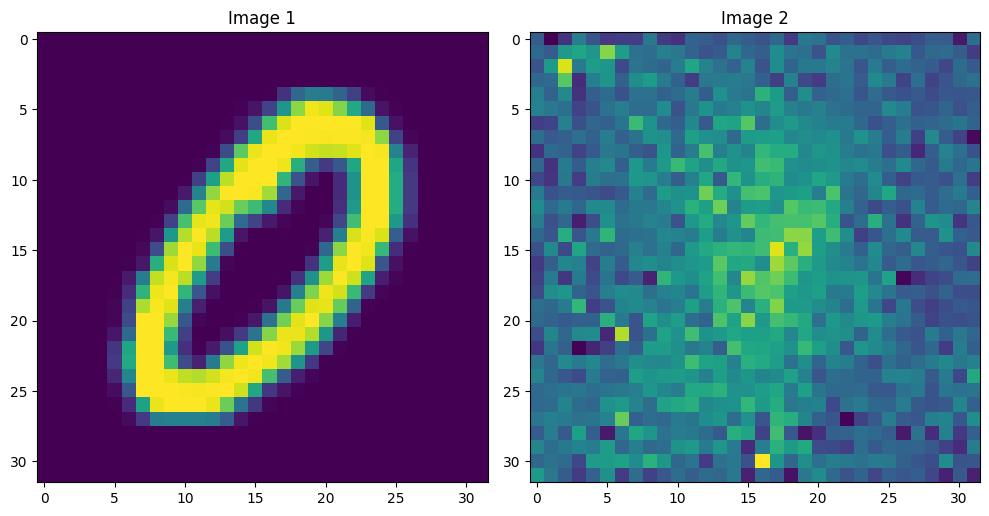

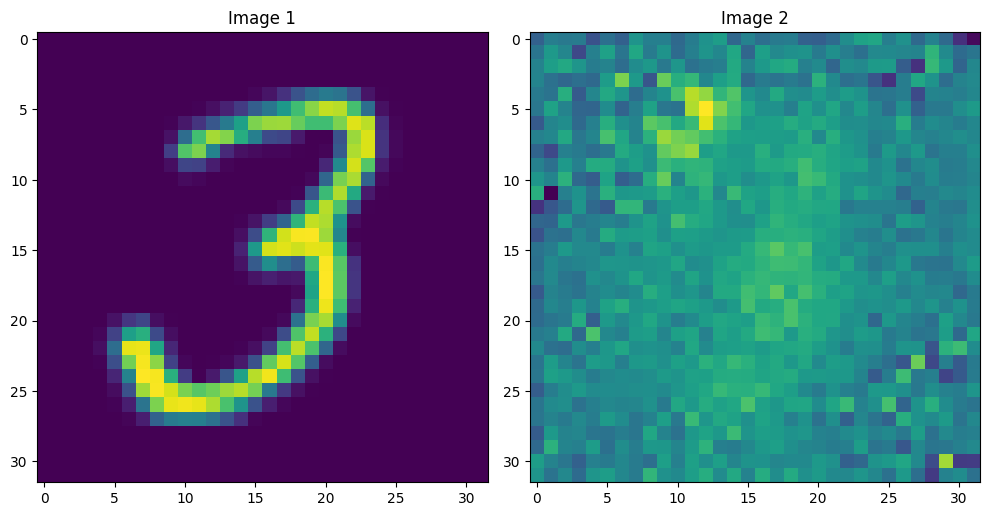

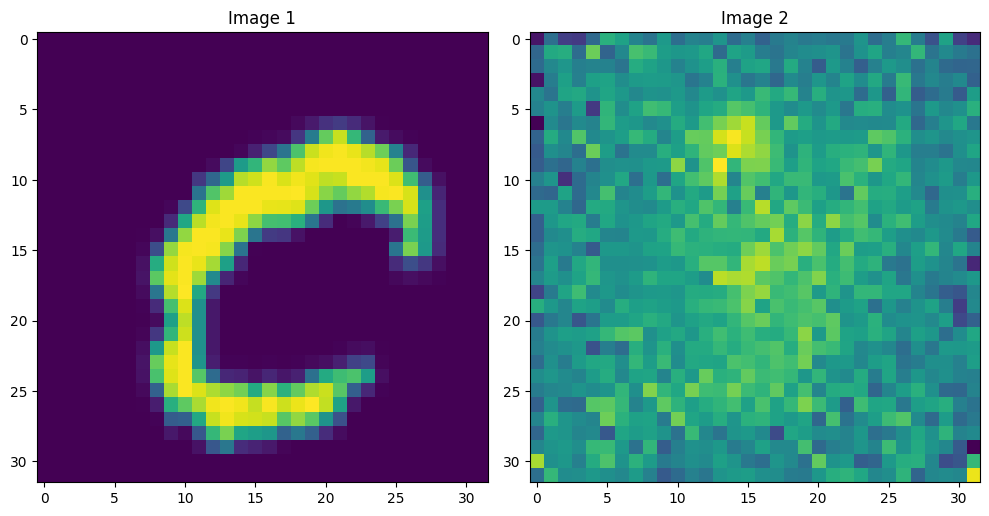

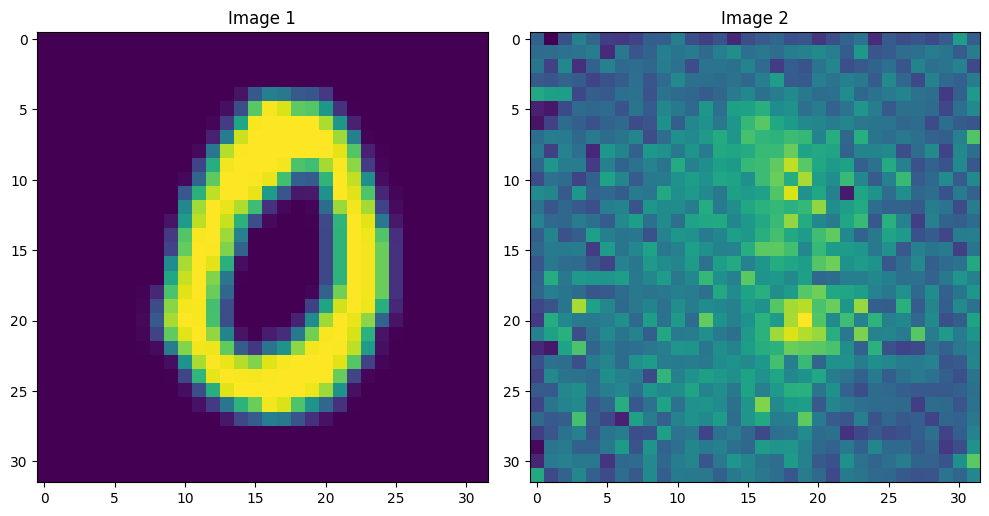

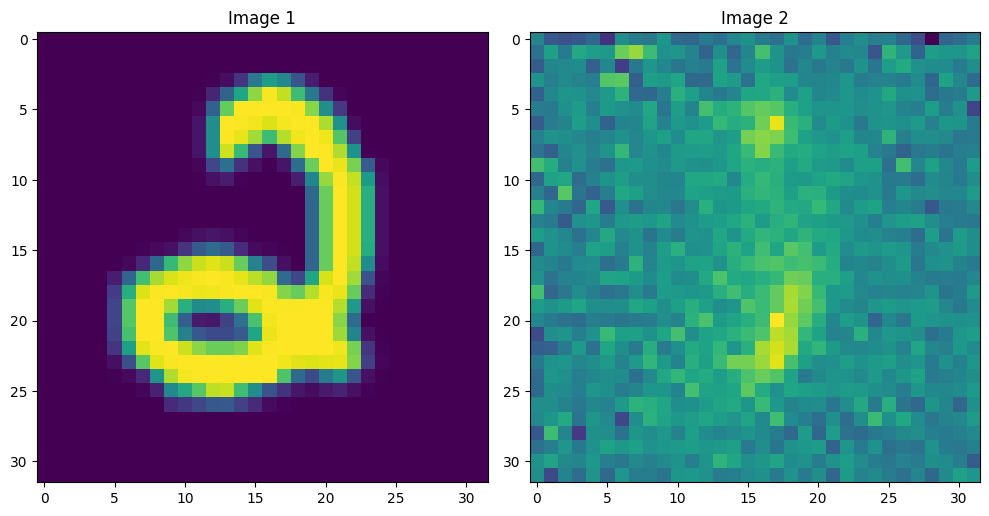

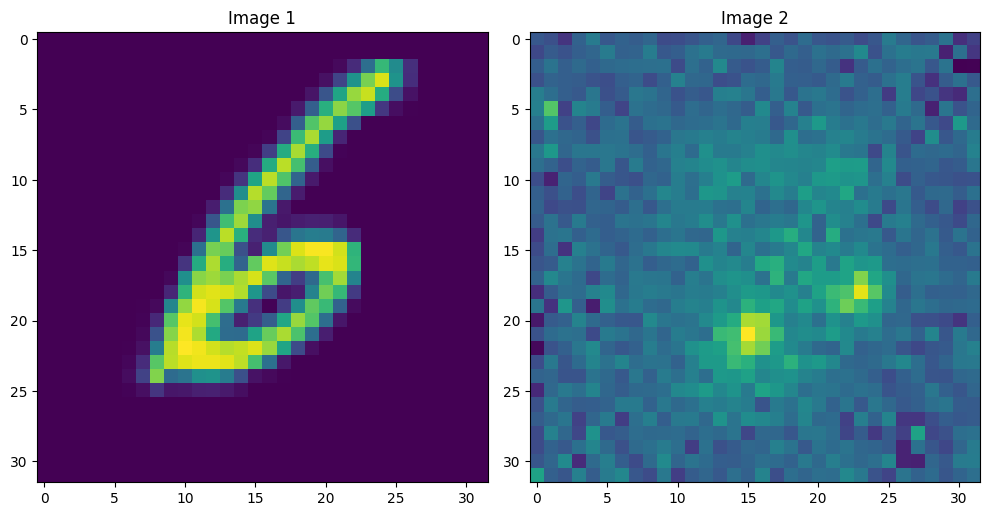

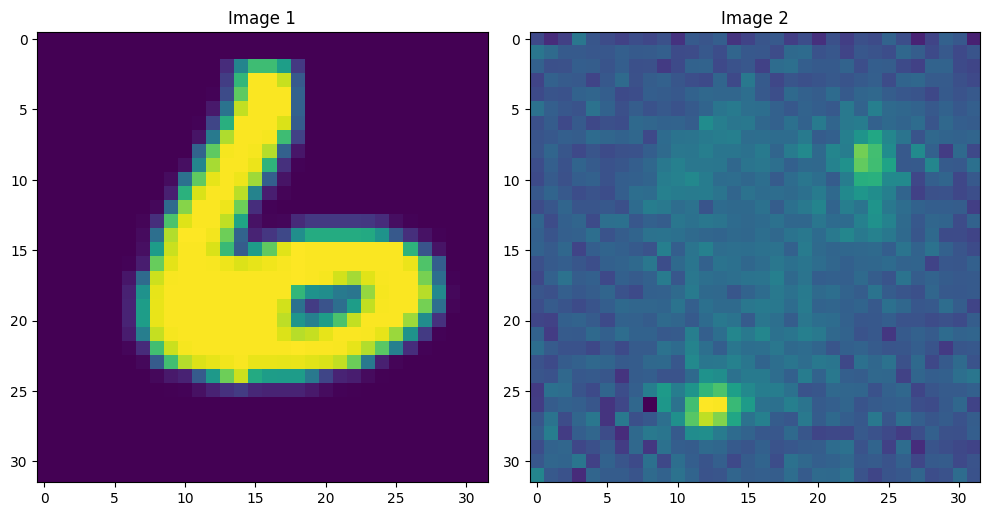

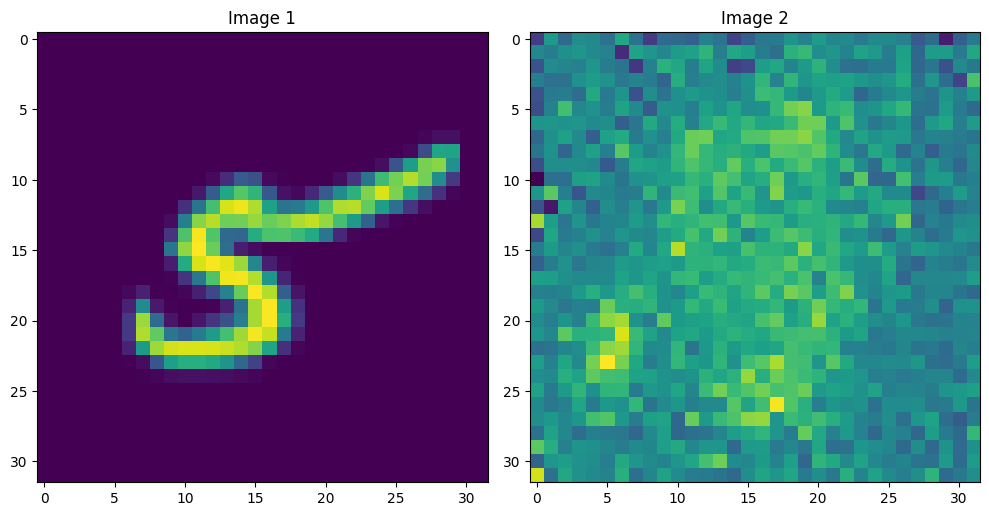

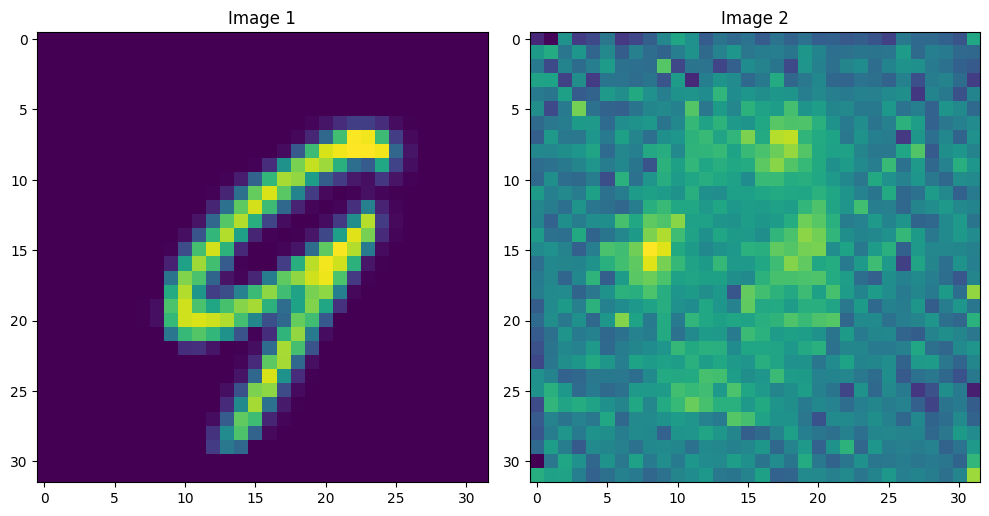

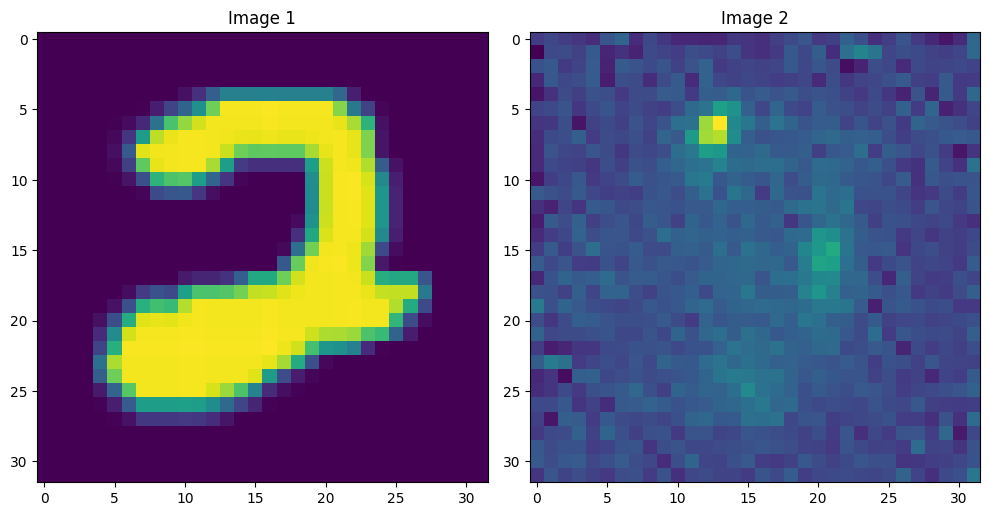

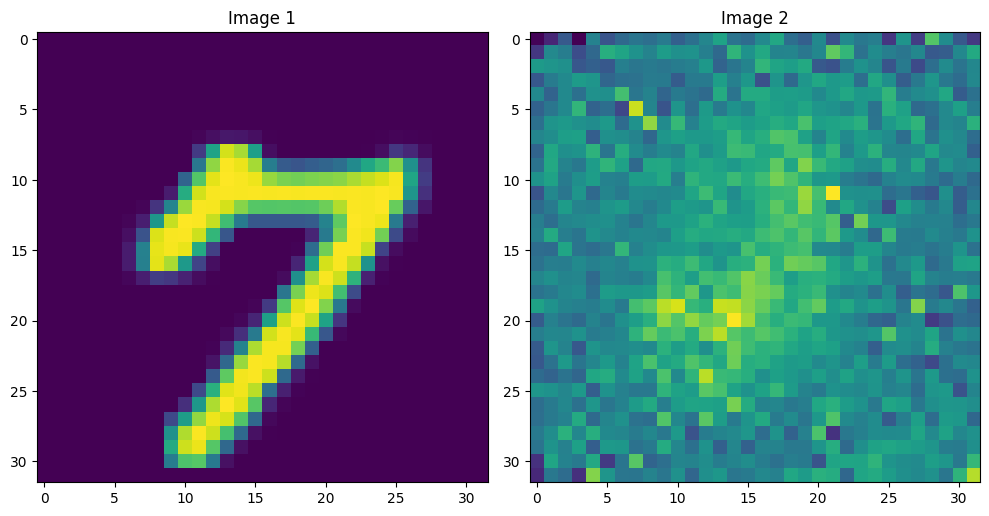

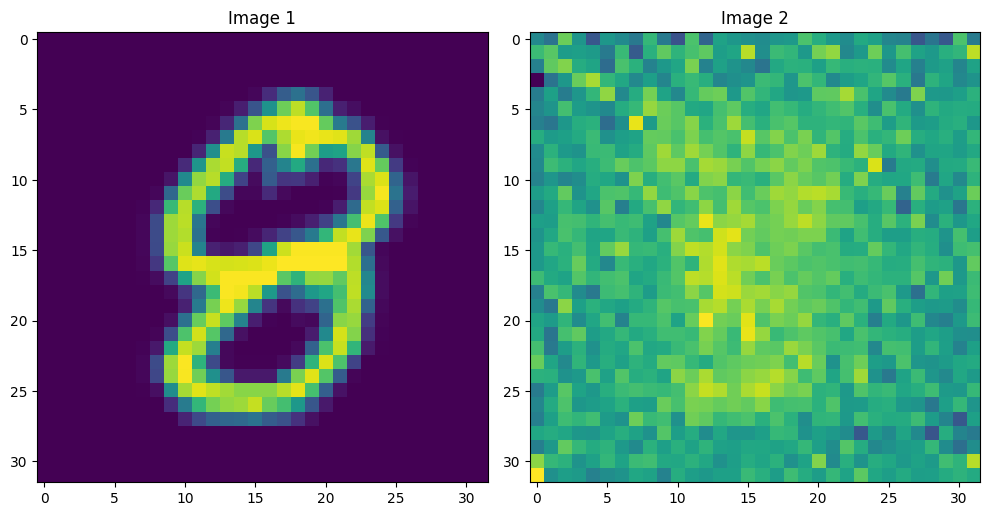

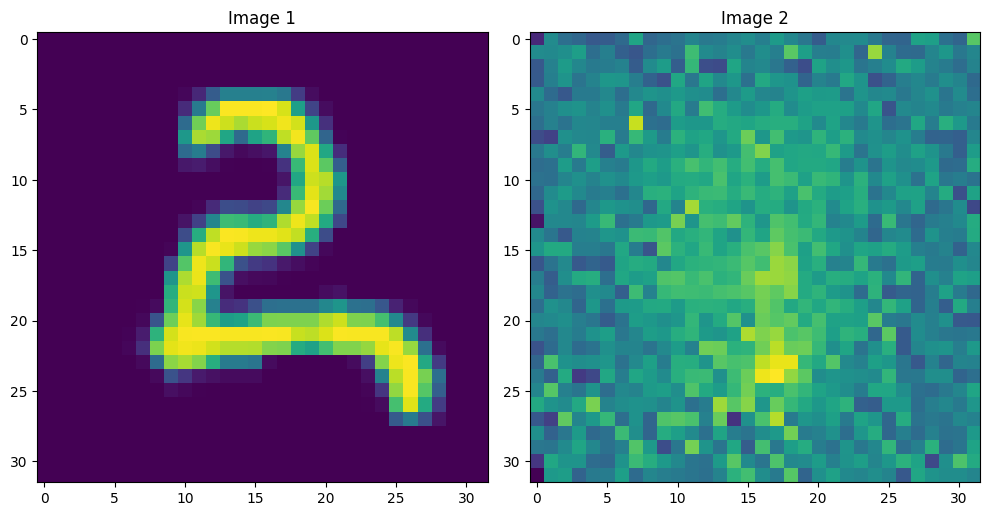

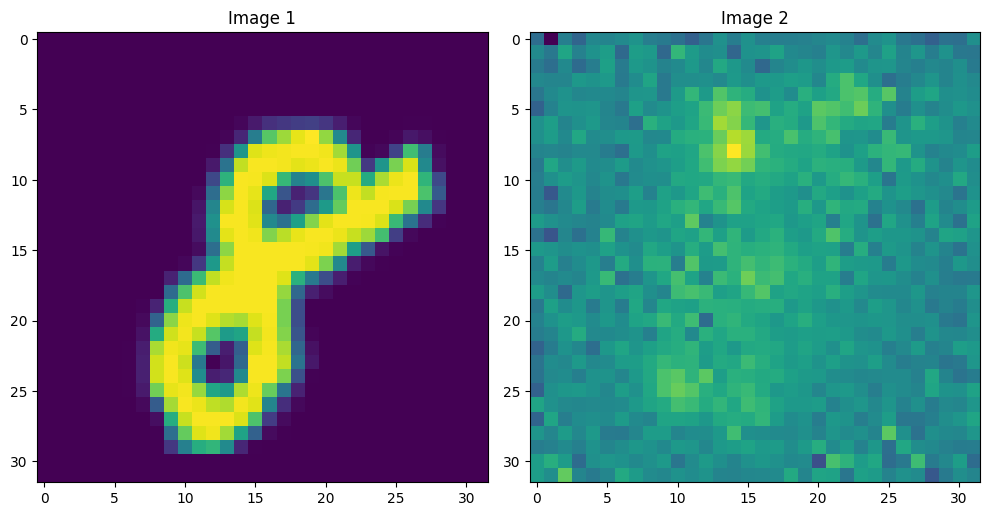

In [95]:
print_result(result_DDIM)

# Evaluation

In [88]:
from transformers import pipeline

pipe = pipeline("image-classification",
                model="farleyknight-org-username/vit-base-mnist",
                device=device)

def convert_to_pil(x):
    res = []
    for i in range(x.shape[0]):
        res.append(to_pil_image(x[i]))
    return res

def help(result):
    res = [0.00000001] * 10
    for r in result:
        res[int(r['label'])] = r['score']
    return res

def inception_model(inputs):
    # inputs : [B, 1, 32, 32]
    out = pipe(convert_to_pil(inputs))
    out = [help(x) for x in out]
    return out

In [91]:
# Function to get inception features
def get_inception_features(dataloader, model, device):
    model.eval()
    features = []
    with torch.no_grad():
        for index, batch in enumerate(dataloader):
            batch = batch['image'].to(device)
            if batch.shape[1] == 1:  # Convert grayscale to RGB
                batch = batch.repeat(1, 3, 1, 1)
            print(batch.shape)
            preds = model(batch)[0].view(batch.size(0), -1)
            features.append(preds.cpu().numpy())
    return np.concatenate(features, axis=0)

# Calculate FID
def calculate_fid(real_features, fake_features):
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

def calculate_inception_score(results):
    scores = []
    for part in results:
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([np.sum(p * np.log(p / py)) for p in part])))
    return np.mean(scores), np.std(scores)

def get_inception_score(result):
    classifier_result = []

    for image, noised_image, denoised_image in result:
        # denoised_image : [B, 1, 32, 32]
        classifier_result += inception_model(denoised_image)

    inception_score_mean, inception_score_std = calculate_inception_score(classifier_result)
    print(f'Inception Score: {inception_score_mean} ± {inception_score_std}')

In [92]:
get_inception_score(result_DDPM)

Inception Score: 1.0771544708267078 ± 0.049716071075187024


In [93]:
get_inception_score(result_DDIM)

Inception Score: 1.225584015096579 ± 0.035470531640961464
